# A verbose walk thru of gaussian-process-regression emulation for global optimization

In this notebook, we go thru much pain to demonstrate how GPR can be used for so-called "bayesian optimization" (BO) with a very naive in-filling strategy.  Many of the steps and operations in this notebook are done only for the purposes of hoping to explain how GPR emulation works in the context of global evolutionary optimization.

We will be using the well-known hosaki function for this analysis

In [1]:
import os
import sys
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyemu

First we need to prepare for the GPR experiments.  Let's get the original model directory and copy it

In [2]:
org_d = os.path.join("..","autotest","utils","hosaki_template")
assert os.path.exists(org_d)

In [3]:
t_d = "hosaki_template"
if os.path.exists(t_d):
    shutil.rmtree(t_d)
shutil.copytree(org_d,t_d)

## uncomment this if you don't have pestpp exes in your path! or you can copy in whatever version exes you'd like into t_d
# pyemu.utils.get_pestpp(t_d)

'hosaki_template'

In [4]:
pst = pyemu.Pst(os.path.join(t_d,"pest.pst"))

In [5]:
par = pst.parameter_data
par

parnme partrans parchglim  parval1  parlbnd  parubnd  pargp  scale  \
parnme                                                                      
par1     par1     none  relative      2.5      0.0      5.0  pargp    1.0   
par2     par2     none  relative      2.5      0.0      5.0  pargp    1.0   

        offset dercom  extra  
parnme                        
par1       0.0      1    NaN  
par2       0.0      1    NaN

The hosaki function only has two decision variables - its very simple.  But in general, GPR-based emulation does not scale to extreme dimensions (like those seem in ensemble-based DA), but well within the space of global (multi-objective) optimization, so its an obvious pairing with pestpp-mou...

The hosaki function only has 1 objective and no constraints and our goal is to minimize this single objective:

In [6]:
pst.observation_data

obsnme    obsval  weight     obgnme  extra
obsnme                                           
sim       sim -2.345812   100.0  less_than    NaN

First, lets sweep over decision variable space so that we can map the "true" objective function surface. You would never do this in practice but it helps us understand the GPR emulation process:

In [7]:
pvals = []
sweep_steps = 30
for p1 in np.linspace(par.parlbnd.iloc[0],par.parubnd.iloc[0],sweep_steps):
    for p2 in np.linspace(par.parlbnd.iloc[0],par.parubnd.iloc[0],sweep_steps):
        pvals.append([p1,p2])
pvals = pd.DataFrame(pvals,columns=pst.par_names)
pvals.to_csv(os.path.join(t_d,"sweep_in.csv"))
pst.pestpp_options["ies_par_en"] = "sweep_in.csv"
pst.control_data.noptmax = -1
sweep_d = os.path.join("hosaki_sweep")
pst.pestpp_options["ies_include_base"] = False

pst.write(os.path.join(t_d,"pest.pst"))
port = 5544
num_workers = 10
sys.path.insert(0,t_d)
from forward_run import hosaki_ppw_worker as ppw_function
pyemu.os_utils.start_workers(t_d,"pestpp-ies","pest.pst",
                             num_workers=num_workers,
                             master_dir=sweep_d,worker_root='.',
                             port=port,ppw_function=ppw_function)

noptmax:-1, npar_adj:2, nnz_obs:1


             pestpp-ies: a GLM iterative ensemble smoother

                   by the PEST++ development team


version: 5.2.19
binary compiled on Apr 28 2025 at 09:25:40

started at 08/28/25 09:37:14
...processing command line: ' pestpp-ies pest.pst /h :5544'
...using panther run manager in master mode using port 5544

using control file: "pest.pst"
in directory: "/Users/jwhite/Dev/pyemu/examples/hosaki_sweep"
on host: "jwhites-MacBook-Pro.local"

processing control file pest.pst
Note: 3 unused lines in pest control file, see rec file...


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... ..  .:::::.     . ..:::::::....:::.  `: .'
    :..

And lets load up the sweep results so we can plot:

In [8]:
sweep_pe = pd.read_csv(os.path.join(sweep_d,"pest.0.par.csv"),index_col=0)
sweep_oe = pd.read_csv(os.path.join(sweep_d,"pest.0.obs.csv"),index_col=0)
sweep_x = sweep_pe.loc[:,pst.par_names[0]].values.reshape(sweep_steps,sweep_steps)
sweep_y = sweep_pe.loc[:,pst.par_names[1]].values.reshape(sweep_steps,sweep_steps)
sweep_z = sweep_oe.loc[:,pst.obs_names[0]].values.reshape(sweep_steps,sweep_steps)

In [9]:
def get_obj_map(ax,_sweep_x,_sweep_y,_sweep_z,label="objective function",
                levels=[-2,-1,0,0.5],vmin=-2,vmax=0.5,cmap="magma"): 
    """a simple function to plot an objective function surface"""
    cb = ax.pcolormesh(_sweep_x,_sweep_y,_sweep_z,vmin=vmin,vmax=vmax,cmap=cmap)
    plt.colorbar(cb,ax=ax,label=label)
    ax.contour(_sweep_x,_sweep_y,_sweep_z,levels=levels,colors="w")
    
    ax.set_aspect("equal")
    return ax

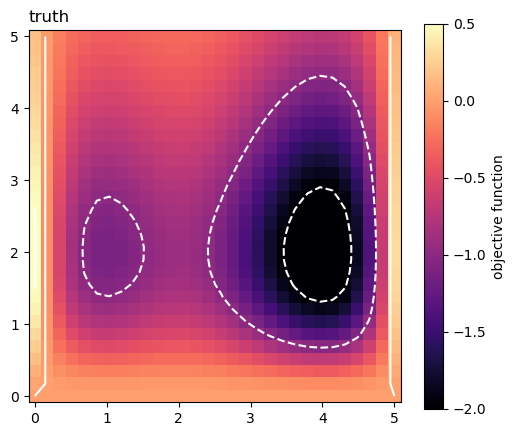

In [10]:
fig,ax = plt.subplots(1,1,figsize=(6,5))
_ = get_obj_map(ax,sweep_x,sweep_y,sweep_z)
ax.set_title("truth",loc="left")
plt.show()
plt.close(fig)

So that is the true objective function surface with the global minimum at (4,2) and a local minimum at (1,2).

The GPR BO workflow starts by first evaluating an initial population with the complex and expensive to run "model", which here is just the simple hosaki function.  In practice, this will be an expensive and complex process based model.  To make this demo more interesting, we will limit the decision variable search space to not include the global minimum (and really 10 members in the initial population is pretty crazy small - just for demo!).  If we dont limit the search space and use a larger initial population, the GPR process nails it in the first go...

In [11]:
m_d = "hosaki_model_master"
if os.path.exists(m_d):
    shutil.rmtree(m_d)
pst.pestpp_options["mou_population_size"] = 10
pst.control_data.noptmax = -1
par = pst.parameter_data
par.loc[pst.par_names[0],"parubnd"] = 3
par.loc[pst.par_names[0],"parval1"] = 1.5
pst.write(os.path.join(t_d,"pest.pst"))
num_workers = 1
pyemu.os_utils.start_workers(t_d,"pestpp-mou","pest.pst",
                                 num_workers=num_workers,
                                 master_dir=m_d,worker_root='.',
                                 port=port,ppw_function=ppw_function)


noptmax:-1, npar_adj:2, nnz_obs:1


             pestpp-mou: multi-objective optimization under uncertainty

                   by the PEST++ development team


version: 5.2.19
binary compiled on Apr 28 2025 at 09:25:40

started at 08/28/25 09:37:41
...processing command line: ' pestpp-mou pest.pst /h :5544'
...using panther run manager in master mode using port 5544

using control file: "pest.pst"
in directory: "/Users/jwhite/Dev/pyemu/examples/hosaki_model_master"
processing control file pest.pst
Note: 3 unused lines in pest control file, see rec file...


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... ..  .:::::.     . ..:::::::....:::.  `: .'
    :..    ____:::::::::.

Now load the initial training input-output pairs

In [12]:
training_dvpop_fname = os.path.join(m_d,"pest.0.dv_pop.csv")
training_opop_fname = os.path.join(m_d,"pest.0.obs_pop.csv")

and we can plot them to visual where we have training points on the actual true surface

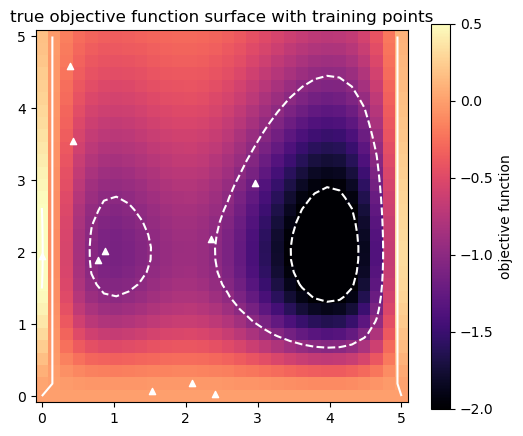

In [13]:
training_dvpop = pd.read_csv(training_dvpop_fname,index_col=0)
training_opop = pd.read_csv(training_opop_fname,index_col=0)
fig,ax = plt.subplots(1,1,figsize=(6,5))
get_obj_map(ax,sweep_x,sweep_y,sweep_z)
ax.scatter(training_dvpop.loc[:,pst.par_names[0]],training_dvpop.loc[:,pst.par_names[1]],marker='^',c='w',s=20)
ax.set_title("true objective function surface with training points")
plt.show()
plt.close(fig)
           

Those white triangles are the places where we have actually run the model - in practice we will never have the colormap or the contours - those are just to help us understand what is happening...and remember: that is a purposefully sparse training dataset!

This function is where the magic happens: we use the decision variable population and resulting output/observation population to setup the GPR emulation process.  Note that `pyemu.helpers.prep_for_gpr()` function setups and training a GPR emulator for each non-zero weighted observation in the control file... 

In [14]:
def prep_for_gpr(t_d,dvpops,opops,gpr_t_d,noptmax=-1):
    # this helper does the heavy lifting.  We are including the optional GPR emulated standard deviations
    # as "observations".  These quantities are the standard deviation of the emulated objective function value
    # with respect to the GPR process - this is a unique and very powerful aspect of GPR vs other
    #data-driven techniques.  We will use these obs to visualize the uncertainty in the 
    # GPR objectve function surface later...
    pyemu.helpers.prep_for_gpr(os.path.join(t_d,"pest.pst"),dvpops,opops,t_d=t_d,gpr_t_d=gpr_t_d,plot_fits=True,
                               include_emulated_std_obs=True)
    # now load the newly created gpr-based pst file:
    gpst = pyemu.Pst(os.path.join(gpr_t_d,"pest.pst"))
    #and copy the sweep input file that lets us run the full response surface
    # in practice, you dont need this either...
    shutil.copy2(os.path.join(sweep_d,"sweep_in.csv"),os.path.join(gpr_t_d,"sweep_in.csv"))
    # some bits and bobs:
    gpst.control_data.noptmax = noptmax
    gpst.pestpp_options["ies_include_base"] = False
    gpst.pestpp_options["mou_save_population_every"] = 1
    gpst.pestpp_options.pop("mou_dv_population_file",None)
    par = gpst.parameter_data
    par.loc[:,"parlbnd"] = 0.0
    par.loc[:,"parubnd"] = 5.0
    par.loc[:,"parval1"] = 2.5    
    
    gpst.write(os.path.join(gpr_t_d,"pest.pst"),version=2)
    return gpst

One important consideration here: In this simple demo, we only have one objective.  That means we have to be careful not to drive the emulator to a single best-fit solution (which we do by using only a few generations when we run mou), but we also need to sure that we start the emulator-driven mou runs with a fully dispersed initial population.  But!  In a multiobjective run, the final generation for mou is naturally disperesed because of the pareto frontier search, so in the multiobjective setting, we probably want to start the emulated mou run with the existing population to keep us from having to re-search all of decision variable space for the nondominated solutions.  This isn't a hard-and-fast rule, but it seems to be generally applicable

The GPR helper in pyemu accepts a list of input and output filenames to make it easier to repeatedly retrain the GPR emulators:

In [15]:
training_dvpop_fnames = [training_dvpop_fname]
training_opop_fnames = [training_opop_fname]

In [16]:
gpr_t_d = t_d + "_gpr"
gpst = prep_for_gpr(t_d,training_dvpop_fnames,training_opop_fnames,gpr_t_d)
# we only need these files in memory so we can use the speed of PyPestWorker later....
input_df = pd.read_csv(os.path.join(gpr_t_d,"gpr_input.csv"),index_col=0)
mdf = pd.read_csv(os.path.join(gpr_t_d,"gprmodel_info.csv"),index_col=0)
mdf["model_fname"] = mdf.model_fname.apply(lambda x: os.path.join(gpr_t_d,x))

using all adjustable parameters as inputs
input names: ['par1', 'par2']
'mou_objectives' not found in ++ options, using all ineq tagged non-zero weighted obs as objectives
objectives: ['sim']
constraints: []
loading input and output files
...loaded hosaki_model_master/pest.0.dv_pop.csv hosaki_model_master/pest.0.obs_pop.csv
aggregated training dataset shape (10, 3) saved to hosaki_template/pest.pst.aggresults.csv
Hyperparameter(name='length_scale', value_type='numeric', bounds=array([[1.e-04, 1.e+04]]), n_elements=1, fixed=False)
training GPR for sim with 10 data points
sim optimized kernel: Matern(length_scale=3.84, nu=0.5)
...plotting fits for sim
GPR model info saved to hosaki_template_gpr/gprmodel_info.csv
noptmax:0, npar_adj:2, nnz_obs:1
saved gpr pst: pest.pst in gpr_t_d hosaki_template_gpr
pestpp-mou pest.pst


             pestpp-mou: multi-objective optimization under uncertainty

                   by the PEST++ development team


version: 5.2.19
binary compiled on Apr 28 202

/Users/jwhite/Dev/pyemu/pyemu/pst/pst_utils.py:922: UserWarning: error processing instruction file hosaki_template_gpr/gpr_output.csv.ins, trying inschek: output file 'hosaki_template_gpr/gpr_output.csv' not found


...exit_code: 92961
...status: 0
08/28/25 09:37:48 forward run command(s) finished, took 0.486 seconds
08/28/25 09:37:48 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
08/28/25 09:37:48 done, took 0 seconds


-->08/28/25 09:37:48 run complete, took: 0.486 seconds
-->1 of 1 complete, 0 failed





    ---  serial run manager runs summary:  ---    
    1 of 1 complete, 0 failed
    process took : 0.486 seconds




...saving results from control file parameter value run to  pest.obs.csv

  ---  control file parameter phi report:  ---  
       phi type           mean            std            min            max
       measured        17422.2              0        17422.2        17422.2
         actual        17422.2              0        17422.2        17422.2
     note: 'measured' phi reported above includes 
           realizations of measurement noise, 
           'actual' phi does not.
  ---  observation group phi summary ---  
       (computed us

In [17]:
gpst.observation_data

obsnme        obsval  weight     obgnme  extra
obsnme                                                        
sim                sim -2.345812e+00   100.0  less_than    NaN
sim_gprstd  sim_gprstd  1.000000e+10     0.0     obgnme    NaN

We see the original "sim" observation (which is the objective function we are trying to minimize), but we also see the optional GPR-estimated standard devivation

Let's see what was created in the new GPR-based template directory:

In [18]:
os.listdir(gpr_t_d)

['pest.pargp_data.csv',
 'pest.obs.csv',
 'gpr_input.csv',
 'pest.base.rei',
 'pest.phi.actual.csv',
 'pest.rec',
 'pest.log',
 'forward_run.py',
 'gpr_fits.pdf',
 'pest.phi.lambda.csv',
 'gprmodel_info.csv',
 'pest.pst.obj_0.pkl',
 'pest.pst',
 'gpr_input.csv.tpl',
 'gpr_aggregate_training_data.csv',
 'gpr_output.csv.ins',
 'gpr_output.csv',
 'pest.rns',
 'pest.phi.regul.csv',
 'pest.par_data.csv',
 'pest.insfile_data.csv',
 'pest.phi.composite.csv',
 'pest.rst',
 'pest.phi.group.csv',
 'pest.phi.meas.csv',
 'pest.base.par',
 'pest.obs_data.csv',
 'pest.tplfile_data.csv',
 'run.info',
 'sweep_in.csv']

two very important files in that dir:  the new forward run python script and a series of pickle files, one per objective and one per active constraint in the optimization problem.  Essentially, we need to build a GPR-based emulator for each output that is relevant to the optimization problem.  We also dont want to rebuild these emulators every time we run the model, so we store the trained GPR emulators in pickle files and load them up as needed:

In [19]:
with open(os.path.join(gpr_t_d,"forward_run.py"),'r') as f:
    for line in f:
        print(line,end="")


import pandas as pd
import os
import pickle
import numpy as np
def get_gpr_model_dict(mdf):
    import pickle
    gpr_model_dict = {}
    for output_name,model_fname in zip(mdf.output_name,mdf.model_fname):
        gaussian_process = pickle.load(open(model_fname,'rb'))
        gpr_model_dict[output_name] = gaussian_process
    return gpr_model_dict

def emulate_with_gpr(input_df,mdf,gpr_model_dict):
    mdf.loc[:,"sim"] = np.nan
    mdf.loc[:,"sim_std"] = np.nan
    for output_name,gaussian_process in gpr_model_dict.items():
        sim = gaussian_process.predict(np.atleast_2d(input_df.parval1.values),return_std=True)
        mdf.loc[output_name,"sim"] = sim[0]
        mdf.loc[output_name,"sim_std"] = sim[1]
    return mdf

def gpr_forward_run():
    """the function to evaluate a set of inputs thru the GPR emulators.\
    This function gets added programmatically to the forward run process"""
    import pandas as pd
    input_df = pd.read_csv("gpr_input.csv",index_col=0)
    mdf = pd.

So we simply loop over all relevant model outputs that have a GPR emulator and "emulate" the value of the model output given the current decision variable values.  easy as!

Now, just for learning, lets sweep over decision variable space but evaluate the GPR emulated objective function value.  You would never do this in practice, but it can be informative:

In [20]:

gpr_sweep_d = sweep_d+"_gpr"
num_workers = 10
pyemu.os_utils.start_workers(gpr_t_d,"pestpp-ies","pest.pst",
                             num_workers=num_workers,
                             master_dir=gpr_sweep_d,worker_root='.',
                             port=port,ppw_function=pyemu.helpers.gpr_pyworker,
                                 ppw_kwargs={"input_df":input_df,
                                            "mdf":mdf})




             pestpp-ies: a GLM iterative ensemble smoother

                   by the PEST++ development team


version: 5.2.19
binary compiled on Apr 28 2025 at 09:25:40

started at 08/28/25 09:37:48
...processing command line: ' pestpp-ies pest.pst /h :5544'
...using panther run manager in master mode using port 5544

using control file: "pest.pst"
in directory: "/Users/jwhite/Dev/pyemu/examples/hosaki_sweep_gpr"
on host: "jwhites-MacBook-Pro.local"

processing control file pest.pst


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... ..  .:::::.     . ..:::::::....:::.  `: .'
    :..    ____:::::::::.  . . ....:::::::::____  ... :
   :... `:~    ^~-:::::..  .........::::

Just a helper function to visual the results of the GPR (re-)training:

In [21]:
def plot_gpr_sweep_results(_gpr_sweep_d,_training_dvpop):
    #load the gpr sweep results to viz the emulated objective function surface
    sweep_gpr_pe = pd.read_csv(os.path.join(_gpr_sweep_d,"pest.0.par.csv"),index_col=0)
    sweep_gpr_oe = pd.read_csv(os.path.join(_gpr_sweep_d,"pest.0.obs.csv"),index_col=0)
    gpr_sweep_x = sweep_gpr_pe.loc[:,gpst.par_names[0]].values.reshape(sweep_steps,sweep_steps)
    gpr_sweep_y = sweep_gpr_pe.loc[:,gpst.par_names[1]].values.reshape(sweep_steps,sweep_steps)
    gpr_sweep_z = sweep_gpr_oe.loc[:,gpst.obs_names[0]].values.reshape(sweep_steps,sweep_steps)
    gpr_sweep_stdev_z = sweep_gpr_oe.loc[:,gpst.obs_names[1]].values.reshape(sweep_steps,sweep_steps)
    
    # plot it up:
    fig, axes = plt.subplots(2,2,figsize=(10,8))
    axes = axes.flatten()
    get_obj_map(axes[0],sweep_x,sweep_y,sweep_z)
    get_obj_map(axes[1],gpr_sweep_x,gpr_sweep_y,gpr_sweep_z)
    axes[1].scatter(_training_dvpop.loc[:,pst.par_names[0]],_training_dvpop.loc[:,pst.par_names[1]],marker='^',c='w',s=20)
    diff = sweep_z-gpr_sweep_z
    amax = np.abs(diff).max()
    get_obj_map(axes[2],gpr_sweep_x,gpr_sweep_y,sweep_z-gpr_sweep_z,label="truth minus emulated",levels=None,vmin=-amax,vmax=amax,cmap="bwr")
    get_obj_map(axes[3],gpr_sweep_x,gpr_sweep_y,gpr_sweep_stdev_z,label="GPR stdev",levels=None,
                vmin=gpr_sweep_stdev_z.min(),vmax=gpr_sweep_stdev_z.max(),cmap="jet")
    axes[2].scatter(training_dvpop.loc[:,pst.par_names[0]],training_dvpop.loc[:,pst.par_names[1]],marker='^',c='w',s=20)
    
    axes[0].set_title("truth",loc="left")
    axes[1].set_title("emulated with training points",loc="left")
    axes[2].set_title("difference with training points",loc="left")
    axes[3].set_title("GPR standard deviation",loc="left")
    plt.show()

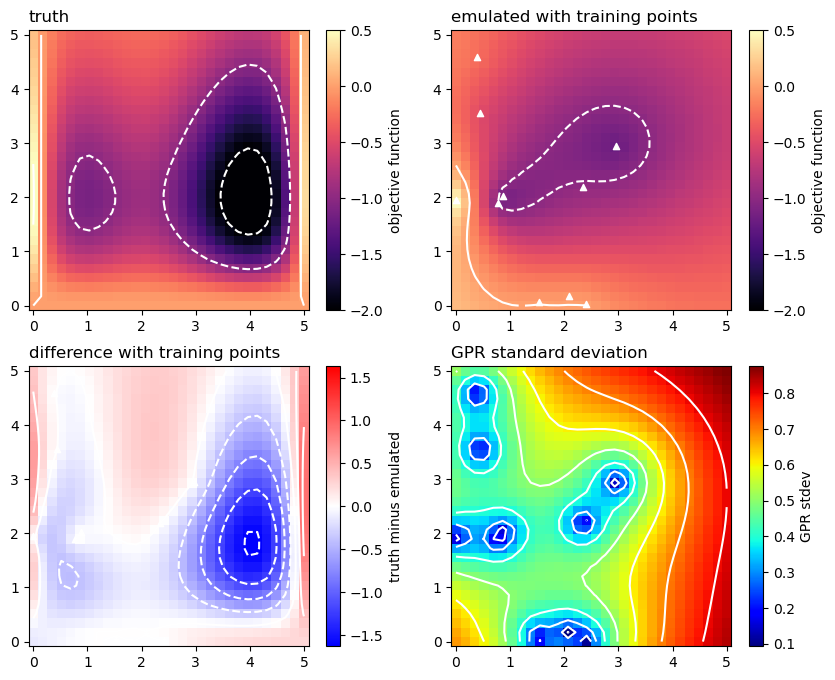

In [22]:
plot_gpr_sweep_results(gpr_sweep_d,training_dvpop)

OK!  now we can see what's happening - the emulated objective function surface is strongly controlled by the location of the training data points, and, is this case, its not a good representation of the truth surface...yet...it should also be clear that the uncertainty in the GPR emulation is lowest near the training points but is highly uncertain as we move away from the training - just like geostatistics!

But now lets run pestpp-mou on the GPR emulated model.  This is usually quite fast, especially if the process model that is being emulated takes more than a few mins to run...

In [23]:
gpst.control_data.noptmax = 8
gpst.pestpp_options["mou_population_size"] = 40
gpst.write(os.path.join(gpr_t_d,"pest.pst"))
gpr_m_d = gpr_t_d.replace("template","master")
num_workers = 3
pyemu.os_utils.start_workers(gpr_t_d,"pestpp-mou","pest.pst",
                             num_workers=num_workers,
                             master_dir=gpr_m_d,worker_root='.',
                             port=port,ppw_function=pyemu.helpers.gpr_pyworker,
                                 ppw_kwargs={"input_df":input_df,
                                            "mdf":mdf})

noptmax:8, npar_adj:2, nnz_obs:1


             pestpp-mou: multi-objective optimization under uncertainty

                   by the PEST++ development team


version: 5.2.19
binary compiled on Apr 28 2025 at 09:25:40

started at 08/28/25 09:38:15
...processing command line: ' pestpp-mou pest.pst /h :5544'
...using panther run manager in master mode using port 5544

using control file: "pest.pst"
in directory: "/Users/jwhite/Dev/pyemu/examples/hosaki_master_gpr"
processing control file pest.pst
Note: 3 unused lines in pest control file, see rec file...


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... ..  .:::::.     . ..:::::::....:::.  `: .'
    :..    ____:::::::::.  .

Now lets plot how the pestpp-mou population evolves across the emulated surface, but also plot it on the true surface just to help us understand what is happening

In [24]:
def plot_gpr_mou_results(_gpr_m_d,_gpr_sweep_d):
    sweep_gpr_pe = pd.read_csv(os.path.join(_gpr_sweep_d,"pest.0.par.csv"),index_col=0)
    sweep_gpr_oe = pd.read_csv(os.path.join(_gpr_sweep_d,"pest.0.obs.csv"),index_col=0)
    gpr_sweep_x = sweep_gpr_pe.loc[:,gpst.par_names[0]].values.reshape(sweep_steps,sweep_steps)
    gpr_sweep_y = sweep_gpr_pe.loc[:,gpst.par_names[1]].values.reshape(sweep_steps,sweep_steps)
    gpr_sweep_z = sweep_gpr_oe.loc[:,gpst.obs_names[0]].values.reshape(sweep_steps,sweep_steps)
    gpr_sweep_stdev_z = sweep_gpr_oe.loc[:,gpst.obs_names[1]].values.reshape(sweep_steps,sweep_steps)
    
    gpr_dvpops = [os.path.join(_gpr_m_d,f) for f in os.listdir(_gpr_m_d) if len(f.split('.')) == 4 and f.endswith("dv_pop.csv") and "archive" not in f]
    gpr_dvpops_itr = [int(f.split(".")[1]) for f in gpr_dvpops]
    gpr_dvpops = {itr:pd.read_csv(f,index_col=0) for itr,f in zip(gpr_dvpops_itr,gpr_dvpops)}
    for itr in range(max(gpr_dvpops_itr)):
        fig,axes = plt.subplots(1,2,figsize=(10,4))
        ax = axes[0]
        get_obj_map(ax,sweep_x,sweep_y,sweep_z)
        ax.scatter(gpr_dvpops[itr].loc[:,gpst.par_names[0]],gpr_dvpops[itr].loc[:,gpst.par_names[1]],marker='.',c='w',s=10)
        ax.set_title("truth generation {0}".format(itr),loc="left")
        ax = axes[1]
        get_obj_map(ax,gpr_sweep_x,gpr_sweep_y,gpr_sweep_z)
        ax.scatter(gpr_dvpops[itr].loc[:,gpst.par_names[0]],gpr_dvpops[itr].loc[:,gpst.par_names[1]],marker='.',c='w',s=10)
        ax.set_title("emulated generation {0}".format(itr),loc="left")
        plt.show()
        plt.close(fig)

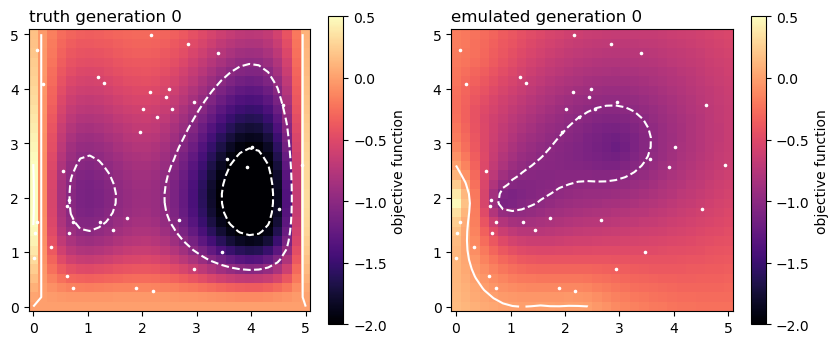

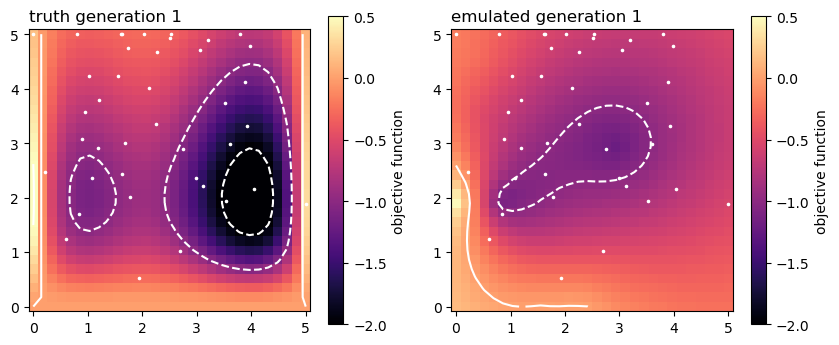

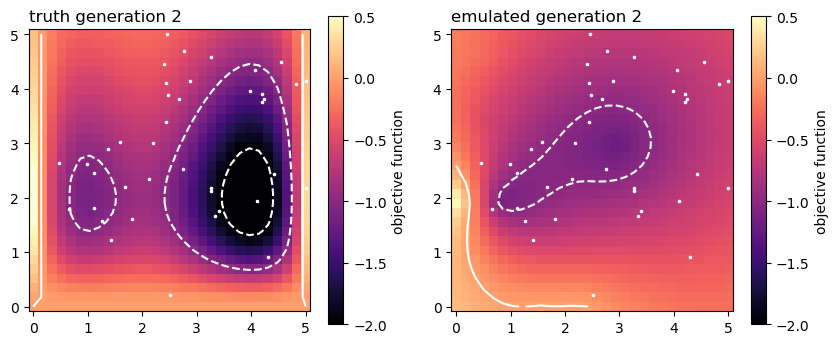

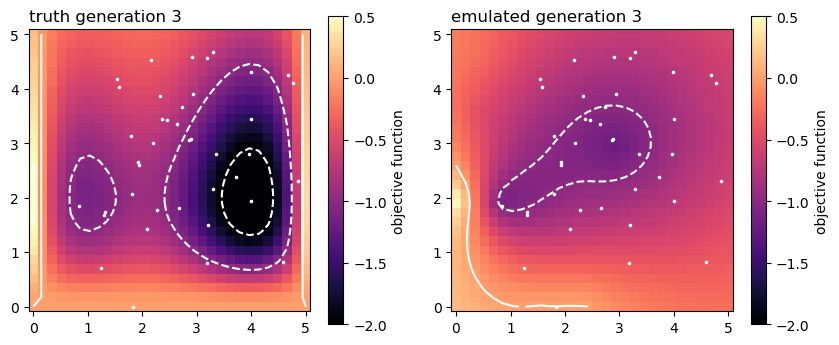

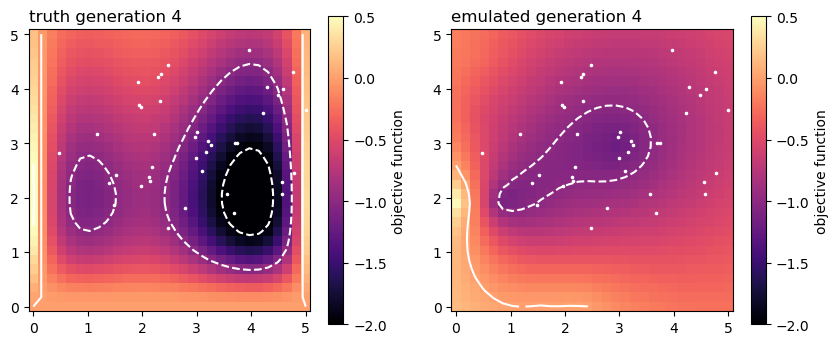

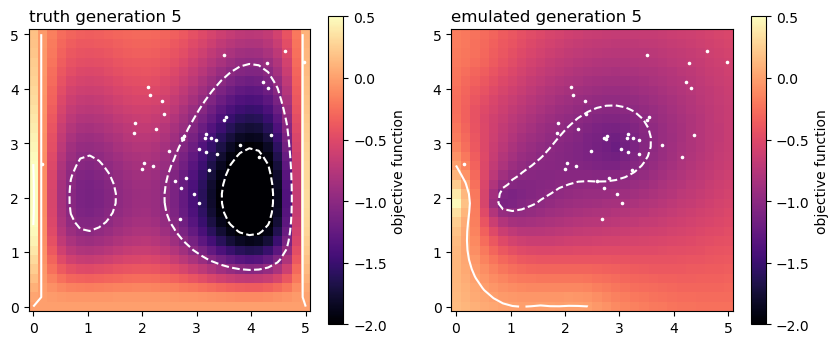

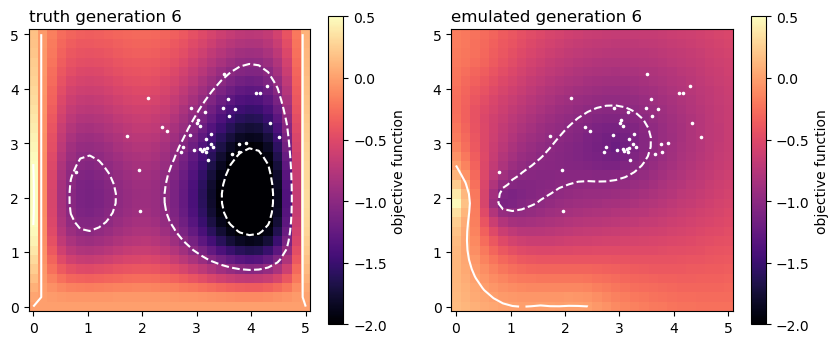

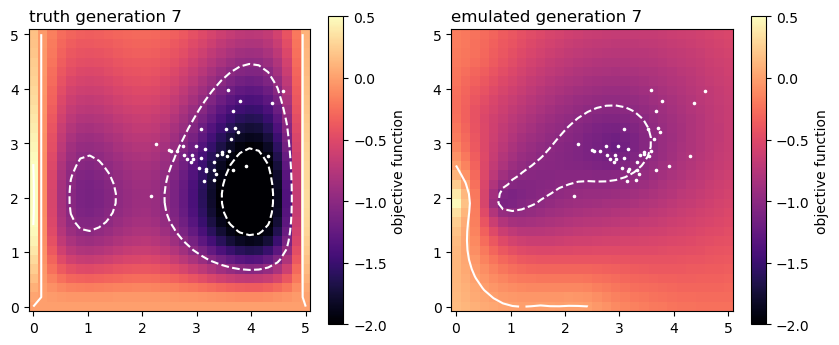

In [25]:
plot_gpr_mou_results(gpr_m_d,gpr_sweep_d)

So just what you expected?  Essentially pestpp-mou converged to the minimum of the objective function we gave it, which is the emulated objective function...at this stage the emulated objective function is a poor representation of the truth objective function....

Now this where some more cleverness happens:  Lets take that last emulated decision variable population and actually run it thru the complex "model" (which in this case is just the hosaki function...).  This is so that we can "in-fill" our GPR emulator with this new points in decision variable space.  In practice, a lot more cleverness needs to happen to actually decide which points, but for this lil demo, it works...

In [26]:
gpr_dvpops = [os.path.join(gpr_m_d,f) for f in os.listdir(gpr_m_d) if len(f.split('.')) == 4 and f.endswith("dv_pop.csv") and "archive" not in f]
gpr_dvpops_itr = [int(f.split(".")[1]) for f in gpr_dvpops]
gpr_dvpops = {itr:pd.read_csv(f,index_col=0) for itr,f in zip(gpr_dvpops_itr,gpr_dvpops)}
# only use the first 10 members of the emulated population to evaluate in the model to make things more interesting
gpr_dvpops[max(gpr_dvpops_itr)].iloc[:10].to_csv(os.path.join(t_d,"retrain_1_dvpop.csv"))
pst.pestpp_options["mou_dv_population_file"] = "retrain_1_dvpop.csv"
pst.control_data.noptmax = -1
pst.write(os.path.join(t_d,"pest.pst"))


noptmax:-1, npar_adj:2, nnz_obs:1


In [27]:
m_d += "_1"
num_workers = 1
pyemu.os_utils.start_workers(t_d,"pestpp-mou","pest.pst",
                                 num_workers=num_workers,
                                 master_dir=m_d,worker_root='.',
                                 port=port,ppw_function=ppw_function)



             pestpp-mou: multi-objective optimization under uncertainty

                   by the PEST++ development team


version: 5.2.19
binary compiled on Apr 28 2025 at 09:25:40

started at 08/28/25 09:38:51
...processing command line: ' pestpp-mou pest.pst /h :5544'
...using panther run manager in master mode using port 5544

using control file: "pest.pst"
in directory: "/Users/jwhite/Dev/pyemu/examples/hosaki_model_master_1"
processing control file pest.pst
Note: 3 unused lines in pest control file, see rec file...


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... ..  .:::::.     . ..:::::::....:::.  `: .'
    :..    ____:::::::::.  . . ....:::::::::____  ... :
 

Now load the newly evaluated training points:

In [28]:
training_dvpop_fname1 = os.path.join(m_d,"pest.0.dv_pop.csv")
training_opop_fname1 = os.path.join(m_d,"pest.0.obs_pop.csv")

And combine these new points with the points we already had (the original few places where we ran the model at the beginning):

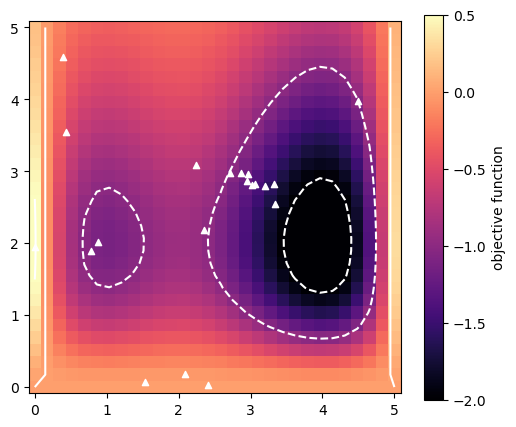

In [29]:
training_dvpop1 = pd.read_csv(training_dvpop_fname1,index_col=0)
training_opop1 = pd.read_csv(training_opop_fname1,index_col=0)
training_dvpop = pd.concat([training_dvpop,training_dvpop1])
training_opop = pd.concat([training_opop,training_opop1])

fig,ax = plt.subplots(1,1,figsize=(6,5))
get_obj_map(ax,sweep_x,sweep_y,sweep_z)
ax.scatter(training_dvpop.loc[:,pst.par_names[0]],training_dvpop.loc[:,pst.par_names[1]],marker='^',c='w',s=20)
plt.show()
plt.close(fig)

See how we have combined the original points and the new points?

Now lets re-do the GPR training process with this combined decision variable and output/observation population

In [30]:
training_dvpop_fnames.append(training_dvpop_fname1)
training_opop_fnames.append(training_opop_fname1)
gpr_t_d = t_d + "_gpr1"
gpst = prep_for_gpr(t_d,training_dvpop_fnames,training_opop_fnames,gpr_t_d)
# we only need these files in memory so we can use the speed of PyPestWorker later....
input_df = pd.read_csv(os.path.join(gpr_t_d,"gpr_input.csv"),index_col=0)
mdf = pd.read_csv(os.path.join(gpr_t_d,"gprmodel_info.csv"),index_col=0)
mdf["model_fname"] = mdf.model_fname.apply(lambda x: os.path.join(gpr_t_d,x))

using all adjustable parameters as inputs
input names: ['par1', 'par2']
'mou_objectives' not found in ++ options, using all ineq tagged non-zero weighted obs as objectives
objectives: ['sim']
constraints: []
loading input and output files
...loaded hosaki_model_master/pest.0.dv_pop.csv hosaki_model_master/pest.0.obs_pop.csv
...loaded hosaki_model_master_1/pest.0.dv_pop.csv hosaki_model_master_1/pest.0.obs_pop.csv
aggregated training dataset shape (20, 3) saved to hosaki_template/pest.pst.aggresults.csv
Hyperparameter(name='length_scale', value_type='numeric', bounds=array([[1.e-04, 1.e+04]]), n_elements=1, fixed=False)
training GPR for sim with 20 data points
sim optimized kernel: Matern(length_scale=6.84, nu=0.5)
...plotting fits for sim
GPR model info saved to hosaki_template_gpr1/gprmodel_info.csv
noptmax:0, npar_adj:2, nnz_obs:1
saved gpr pst: pest.pst in gpr_t_d hosaki_template_gpr1
pestpp-mou pest.pst


             pestpp-mou: multi-objective optimization under uncertainty

    

/Users/jwhite/Dev/pyemu/pyemu/pst/pst_utils.py:922: UserWarning: error processing instruction file hosaki_template_gpr1/gpr_output.csv.ins, trying inschek: output file 'hosaki_template_gpr1/gpr_output.csv' not found


...exit_code: 93067
...status: 0
08/28/25 09:38:58 forward run command(s) finished, took 0.5 seconds
08/28/25 09:38:58 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
08/28/25 09:38:58 done, took 0 seconds


-->08/28/25 09:38:58 run complete, took: 0.501 seconds
-->1 of 1 complete, 0 failed





    ---  serial run manager runs summary:  ---    
    1 of 1 complete, 0 failed
    process took : 0.501 seconds




...saving results from control file parameter value run to  pest.obs.csv

  ---  control file parameter phi report:  ---  
       phi type           mean            std            min            max
       measured        20310.4              0        20310.4        20310.4
         actual        20310.4              0        20310.4        20310.4
     note: 'measured' phi reported above includes 
           realizations of measurement noise, 
           'actual' phi does not.
  ---  observation group phi summary ---  
       (computed usin

Ok, now let's also re-sweep over the emulated surface to see how much better our approximation to the true objective function surface (remember dont do this in practice!  we are just doing it here to help build understanding):

In [31]:
gpr_sweep_d = sweep_d+"_gpr1"
num_workers = 10
pyemu.os_utils.start_workers(gpr_t_d,"pestpp-ies","pest.pst",
                             num_workers=num_workers,
                             master_dir=gpr_sweep_d,worker_root='.',
                             port=port,ppw_function=pyemu.helpers.gpr_pyworker,
                                 ppw_kwargs={"input_df":input_df,
                                            "mdf":mdf})



             pestpp-ies: a GLM iterative ensemble smoother

                   by the PEST++ development team


version: 5.2.19
binary compiled on Apr 28 2025 at 09:25:40

started at 08/28/25 09:38:58
...processing command line: ' pestpp-ies pest.pst /h :5544'
...using panther run manager in master mode using port 5544

using control file: "pest.pst"
in directory: "/Users/jwhite/Dev/pyemu/examples/hosaki_sweep_gpr1"
on host: "jwhites-MacBook-Pro.local"

processing control file pest.pst


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... ..  .:::::.     . ..:::::::....:::.  `: .'
    :..    ____:::::::::.  . . ....:::::::::____  ... :
   :... `:~    ^~-:::::..  .........:::

And now visualize these new surfaces with the current training dataset:

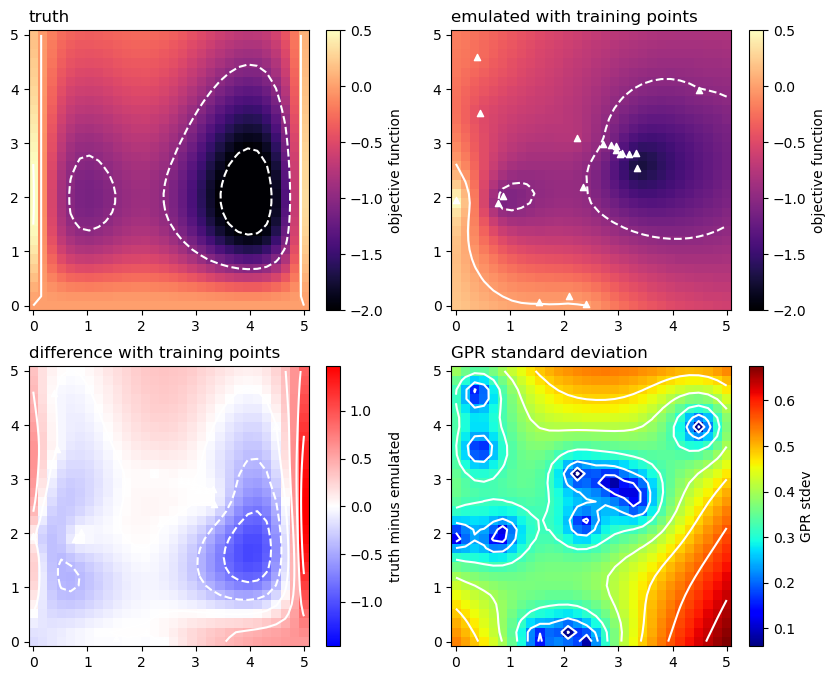

In [32]:
plot_gpr_sweep_results(gpr_sweep_d,training_dvpop)

Comparing this to the original emulated surface, we can see that our emulated objective function surface has improved dramatically!

Now let's run pestpp-mou on this improved emulated model and visualize how pestpp-mou navigates this new emulated surface:

noptmax:8, npar_adj:2, nnz_obs:1


             pestpp-mou: multi-objective optimization under uncertainty

                   by the PEST++ development team


version: 5.2.19
binary compiled on Apr 28 2025 at 09:25:40

started at 08/28/25 09:39:25
...processing command line: ' pestpp-mou pest.pst /h :5544'
...using panther run manager in master mode using port 5544

using control file: "pest.pst"
in directory: "/Users/jwhite/Dev/pyemu/examples/hosaki_master_gpr1"
processing control file pest.pst
Note: 3 unused lines in pest control file, see rec file...


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... ..  .:::::.     . ..:::::::....:::.  `: .'
    :..    ____:::::::::.  

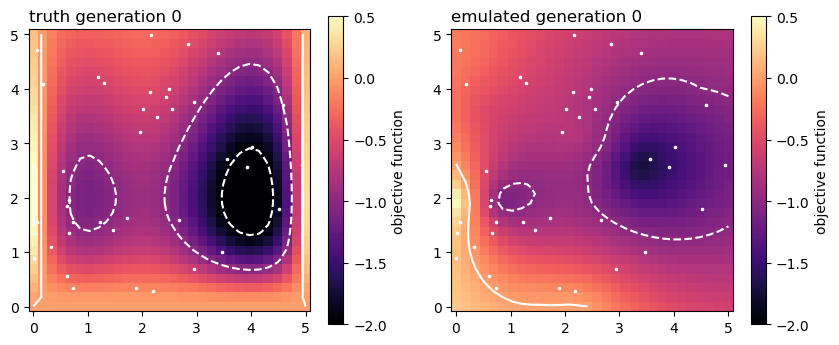

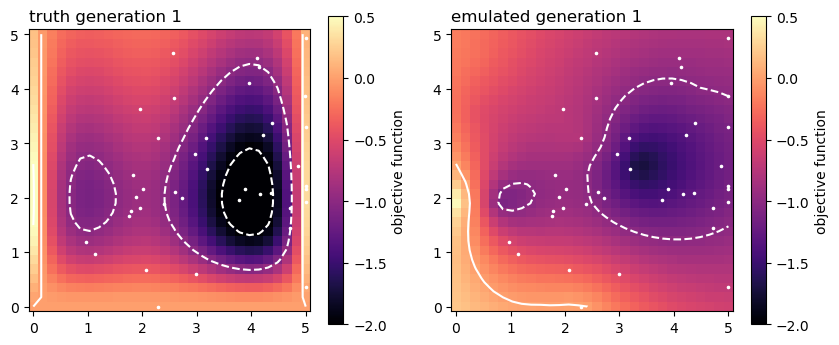

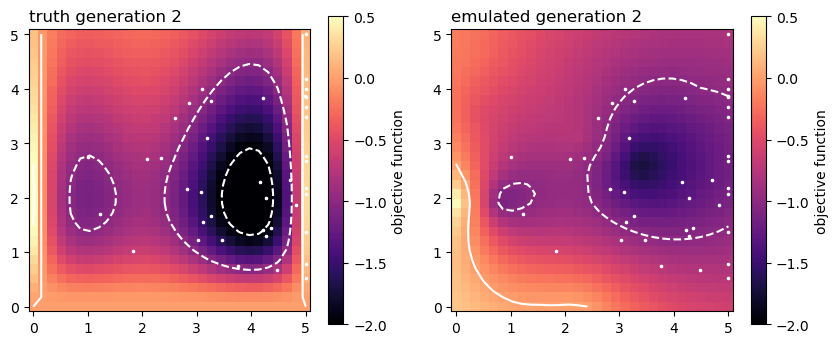

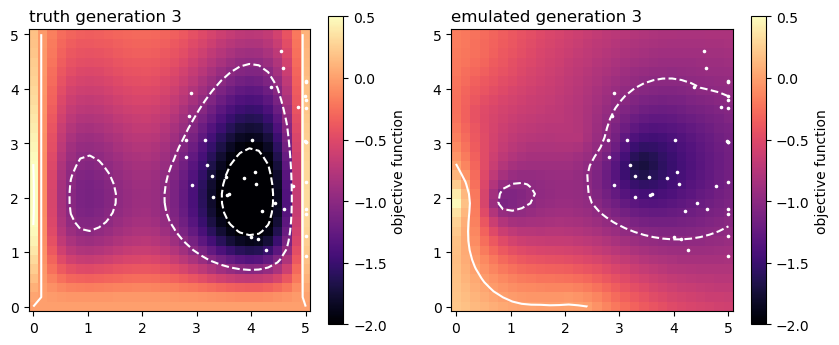

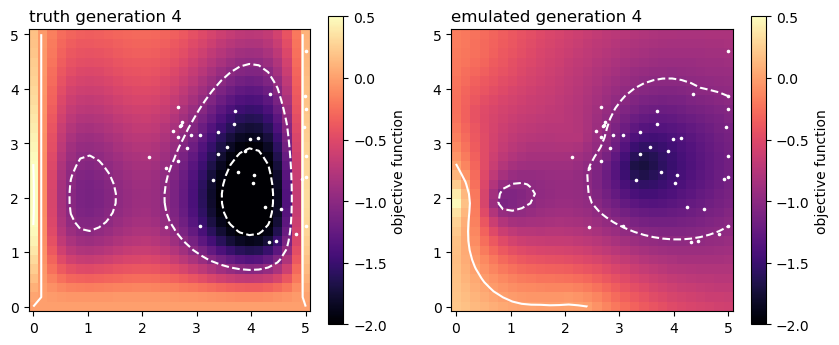

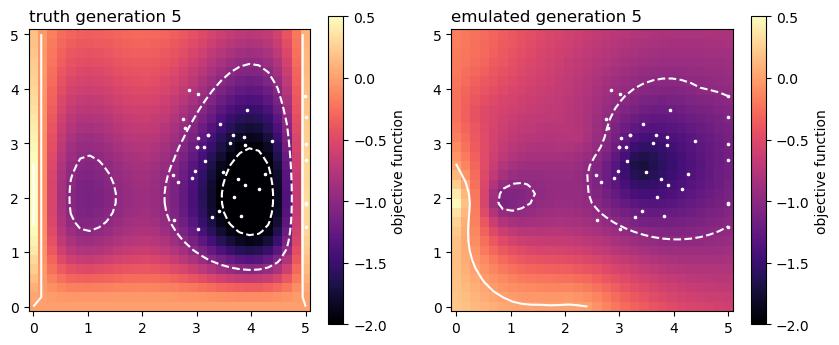

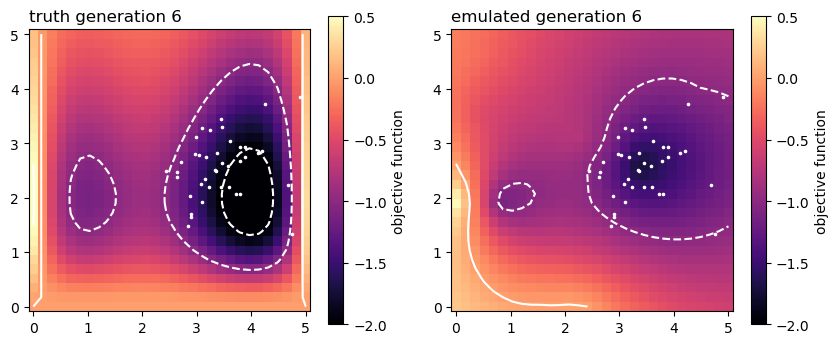

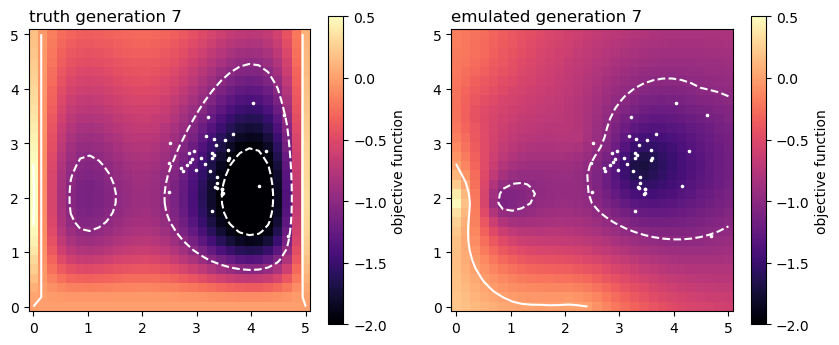

In [33]:
gpst.control_data.noptmax = 8
gpst.pestpp_options["mou_population_size"] = 40
gpst.write(os.path.join(gpr_t_d,"pest.pst"))
gpr_m_d = gpr_t_d.replace("template","master")
num_workers = 3
pyemu.os_utils.start_workers(gpr_t_d,"pestpp-mou","pest.pst",
                             num_workers=num_workers,
                             master_dir=gpr_m_d,worker_root='.',
                             port=port,ppw_function=pyemu.helpers.gpr_pyworker,
                                 ppw_kwargs={"input_df":input_df,
                                            "mdf":mdf})
plot_gpr_mou_results(gpr_m_d,gpr_sweep_d)

Now lets do this whole process a few times:

noptmax:-1, npar_adj:2, nnz_obs:1


             pestpp-mou: multi-objective optimization under uncertainty

                   by the PEST++ development team


version: 5.2.19
binary compiled on Apr 28 2025 at 09:25:40

started at 08/28/25 09:40:02
...processing command line: ' pestpp-mou pest.pst /h :5544'
...using panther run manager in master mode using port 5544

using control file: "pest.pst"
in directory: "/Users/jwhite/Dev/pyemu/examples/hosaki_model_2"
processing control file pest.pst
Note: 3 unused lines in pest control file, see rec file...


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... ..  .:::::.     . ..:::::::....:::.  `: .'
    :..    ____:::::::::.  . .

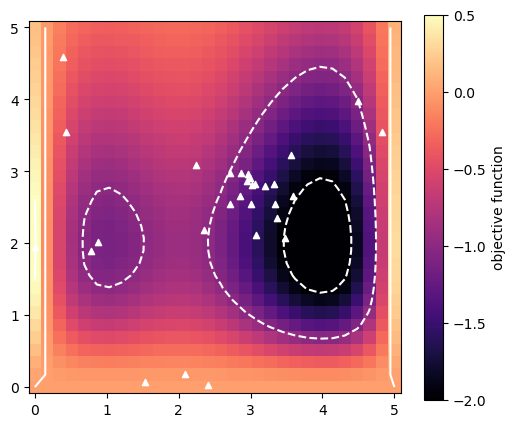

using all adjustable parameters as inputs
input names: ['par1', 'par2']
'mou_objectives' not found in ++ options, using all ineq tagged non-zero weighted obs as objectives
objectives: ['sim']
constraints: []
loading input and output files
...loaded hosaki_model_master/pest.0.dv_pop.csv hosaki_model_master/pest.0.obs_pop.csv
...loaded hosaki_model_master_1/pest.0.dv_pop.csv hosaki_model_master_1/pest.0.obs_pop.csv
...loaded hosaki_model_2/pest.0.dv_pop.csv hosaki_model_2/pest.0.obs_pop.csv
aggregated training dataset shape (30, 3) saved to hosaki_template/pest.pst.aggresults.csv
Hyperparameter(name='length_scale', value_type='numeric', bounds=array([[1.e-04, 1.e+04]]), n_elements=1, fixed=False)
training GPR for sim with 30 data points
sim optimized kernel: Matern(length_scale=7.25, nu=0.5)
...plotting fits for sim
GPR model info saved to hosaki_template_gpr2/gprmodel_info.csv
noptmax:0, npar_adj:2, nnz_obs:1
saved gpr pst: pest.pst in gpr_t_d hosaki_template_gpr2
pestpp-mou pest.pst




/Users/jwhite/Dev/pyemu/pyemu/pst/pst_utils.py:922: UserWarning: error processing instruction file hosaki_template_gpr2/gpr_output.csv.ins, trying inschek: output file 'hosaki_template_gpr2/gpr_output.csv' not found


...exit_code: 93172
...status: 0
08/28/25 09:40:08 forward run command(s) finished, took 0.5 seconds
08/28/25 09:40:08 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
08/28/25 09:40:08 done, took 0 seconds


-->08/28/25 09:40:08 run complete, took: 0.501 seconds
-->1 of 1 complete, 0 failed





    ---  serial run manager runs summary:  ---    
    1 of 1 complete, 0 failed
    process took : 0.501 seconds




...saving results from control file parameter value run to  pest.obs.csv

  ---  control file parameter phi report:  ---  
       phi type           mean            std            min            max
       measured        20568.5              0        20568.5        20568.5
         actual        20568.5              0        20568.5        20568.5
     note: 'measured' phi reported above includes 
           realizations of measurement noise, 
           'actual' phi does not.
  ---  observation group phi summary ---  
       (computed usin

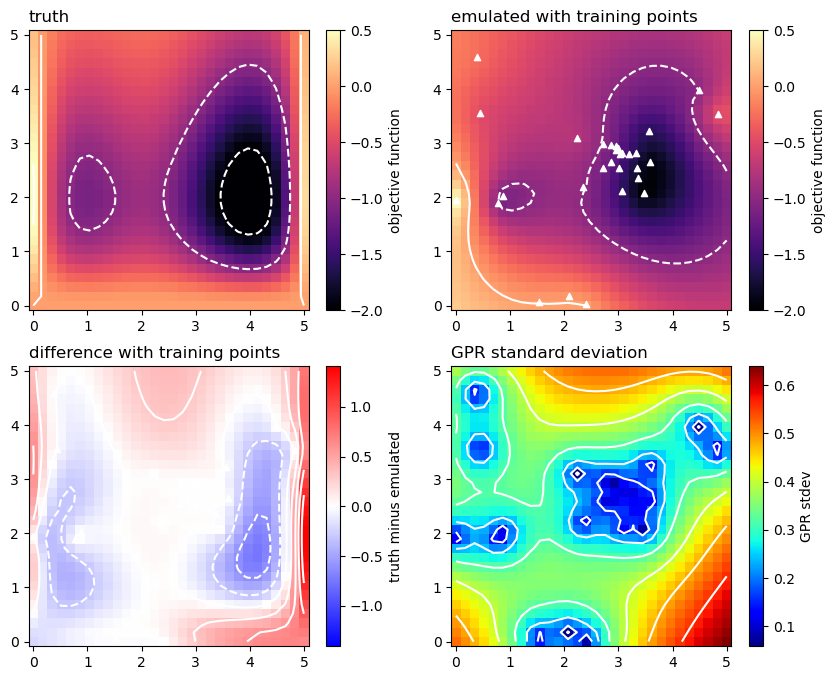

In [34]:
i = 2
gpr_t_d = t_d + "_gpr{0}".format(i-1)
gpr_m_d = gpr_t_d.replace("template","master")
gpr_dvpops = [os.path.join(gpr_m_d,f) for f in os.listdir(gpr_m_d) if len(f.split('.')) == 4 and f.endswith("dv_pop.csv") and "archive" not in f]
gpr_dvpops_itr = [int(f.split(".")[1]) for f in gpr_dvpops]
gpr_dvpops = {itr:pd.read_csv(f,index_col=0) for itr,f in zip(gpr_dvpops_itr,gpr_dvpops)}
# only use the first 10 members of the emulated population to evaluate in the model to make things more interesting
gpr_dvpops[max(gpr_dvpops_itr)].iloc[:10,:].to_csv(os.path.join(t_d,"retrain_{0}_dvpop.csv".format(i)))
pst.pestpp_options["mou_dv_population_file"] = "retrain_{0}_dvpop.csv".format(i)
pst.control_data.noptmax = -1
pst.write(os.path.join(t_d,"pest.pst"))
m_d = "hosaki_model_{0}".format(i)
num_workers = 1
pyemu.os_utils.start_workers(t_d,"pestpp-mou","pest.pst",
                                 num_workers=num_workers,
                                 master_dir=m_d,worker_root='.',
                                 port=port,ppw_function=ppw_function)

training_dvpop_fnamei = os.path.join(m_d,"pest.0.dv_pop.csv")
training_opop_fnamei = os.path.join(m_d,"pest.0.obs_pop.csv")

training_dvpopi = pd.read_csv(training_dvpop_fnamei,index_col=0)
training_opopi = pd.read_csv(training_opop_fnamei,index_col=0)
training_dvpop = pd.concat([training_dvpop,training_dvpopi])
training_opop = pd.concat([training_opop,training_opopi])

fig,ax = plt.subplots(1,1,figsize=(6,5))
get_obj_map(ax,sweep_x,sweep_y,sweep_z)
ax.scatter(training_dvpop.loc[:,pst.par_names[0]],training_dvpop.loc[:,pst.par_names[1]],marker='^',c='w',s=20)
plt.show()
plt.close(fig)

training_dvpop_fnames.append(training_dvpop_fnamei)
training_opop_fnames.append(training_opop_fnamei)

gpr_t_d = t_d + "_gpr{0}".format(i)
gpr_m_d = gpr_t_d.replace("template","master")
gpst = prep_for_gpr(t_d,training_dvpop_fnames,training_opop_fnames,gpr_t_d)
# we only need these files in memory so we can use the speed of PyPestWorker later....
input_df = pd.read_csv(os.path.join(gpr_t_d,"gpr_input.csv"),index_col=0)
mdf = pd.read_csv(os.path.join(gpr_t_d,"gprmodel_info.csv"),index_col=0)
mdf["model_fname"] = mdf.model_fname.apply(lambda x: os.path.join(gpr_t_d,x))
gpr_sweep_d = sweep_d+"_gpr{0}".format(i)
num_workers = 10
pyemu.os_utils.start_workers(gpr_t_d,"pestpp-ies","pest.pst",
                             num_workers=num_workers,
                             master_dir=gpr_sweep_d,worker_root='.',
                             port=port,ppw_function=pyemu.helpers.gpr_pyworker,
                                 ppw_kwargs={"input_df":input_df,
                                            "mdf":mdf})

plot_gpr_sweep_results(gpr_sweep_d,training_dvpop)



noptmax:8, npar_adj:2, nnz_obs:1


             pestpp-mou: multi-objective optimization under uncertainty

                   by the PEST++ development team


version: 5.2.19
binary compiled on Apr 28 2025 at 09:25:40

started at 08/28/25 09:40:35
...processing command line: ' pestpp-mou pest.pst /h :5544'
...using panther run manager in master mode using port 5544

using control file: "pest.pst"
in directory: "/Users/jwhite/Dev/pyemu/examples/hosaki_master_gpr2"
processing control file pest.pst
Note: 3 unused lines in pest control file, see rec file...


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... ..  .:::::.     . ..:::::::....:::.  `: .'
    :..    ____:::::::::.  

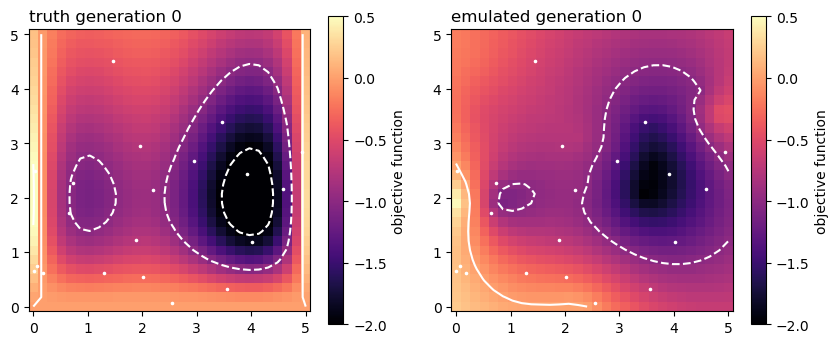

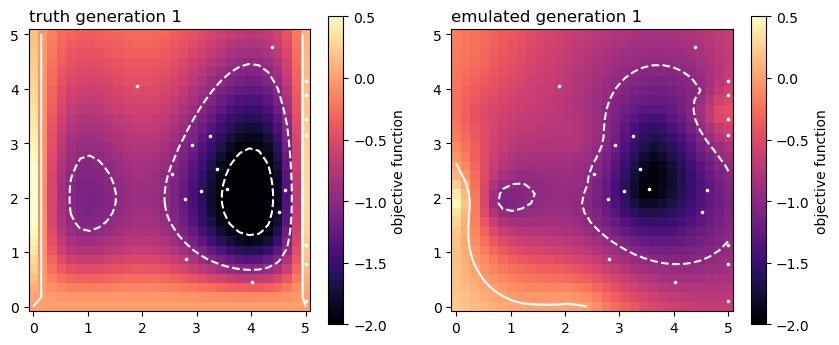

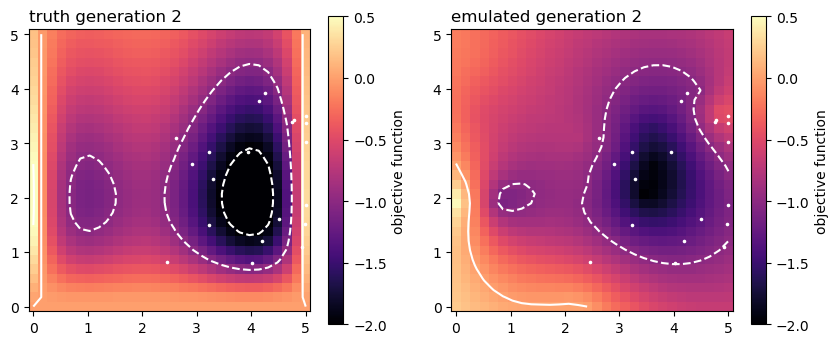

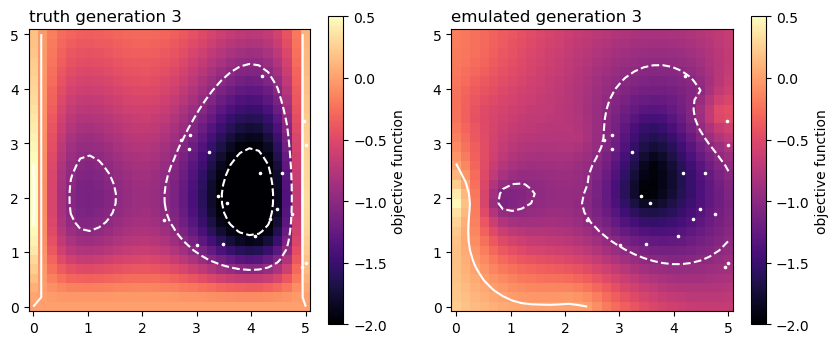

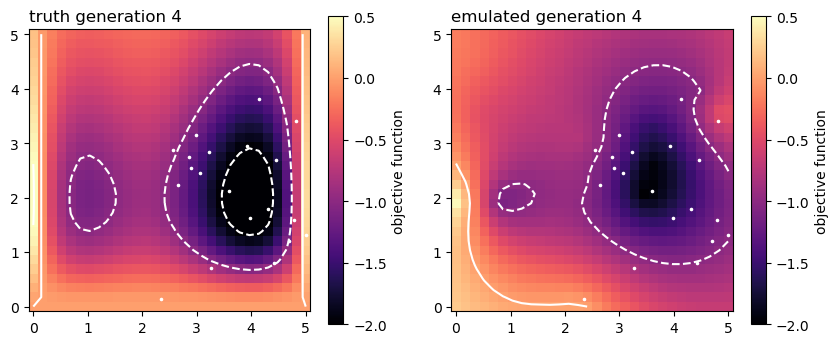

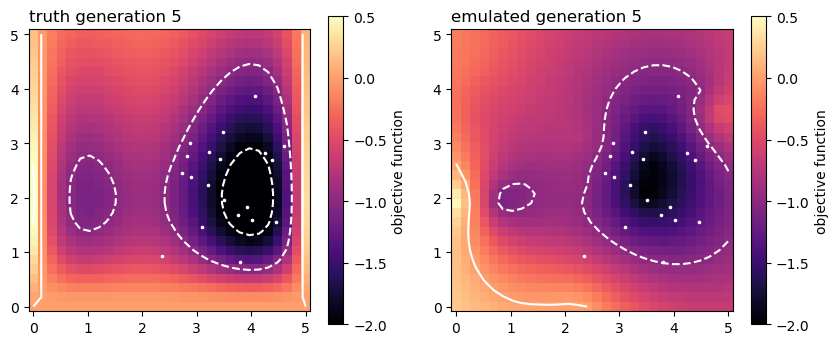

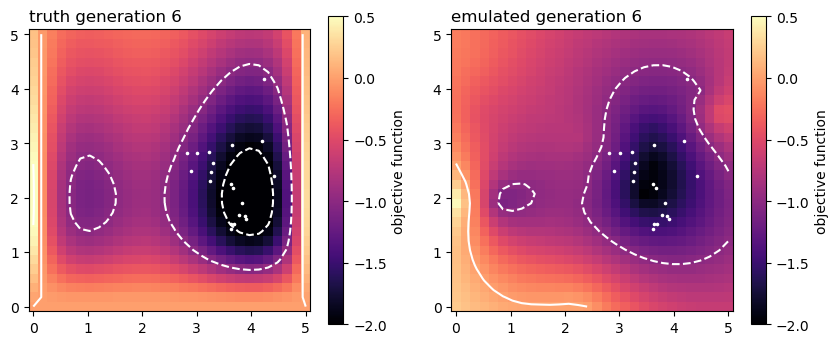

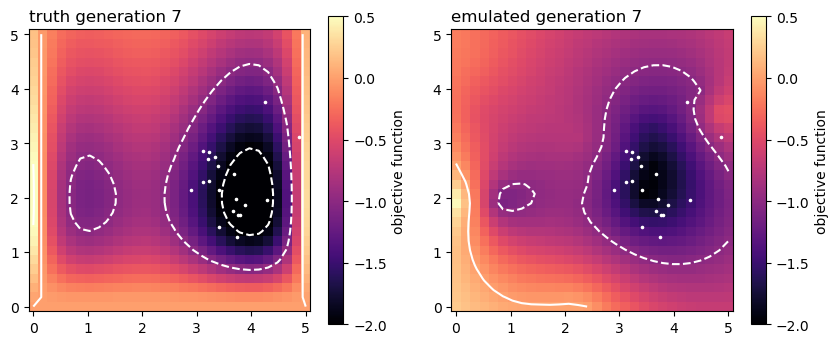

In [35]:
gpst.control_data.noptmax = 8
gpst.pestpp_options["mou_population_size"] = 20
gpst.write(os.path.join(gpr_t_d,"pest.pst"))

num_workers = 3
pyemu.os_utils.start_workers(gpr_t_d,"pestpp-mou","pest.pst",
                             num_workers=num_workers,
                             master_dir=gpr_m_d,worker_root='.',
                             port=port,ppw_function=pyemu.helpers.gpr_pyworker,
                                 ppw_kwargs={"input_df":input_df,
                                            "mdf":mdf})



plot_gpr_mou_results(gpr_m_d,gpr_sweep_d)

noptmax:-1, npar_adj:2, nnz_obs:1


             pestpp-mou: multi-objective optimization under uncertainty

                   by the PEST++ development team


version: 5.2.19
binary compiled on Apr 28 2025 at 09:25:40

started at 08/28/25 09:40:56
...processing command line: ' pestpp-mou pest.pst /h :5544'
...using panther run manager in master mode using port 5544

using control file: "pest.pst"
in directory: "/Users/jwhite/Dev/pyemu/examples/hosaki_model_3"
processing control file pest.pst
Note: 3 unused lines in pest control file, see rec file...


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... ..  .:::::.     . ..:::::::....:::.  `: .'
    :..    ____:::::::::.  . .

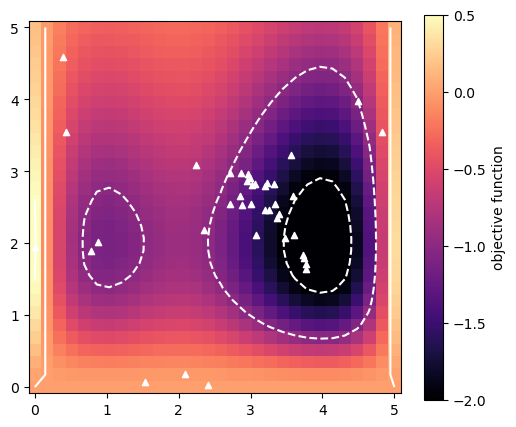

using all adjustable parameters as inputs
input names: ['par1', 'par2']
'mou_objectives' not found in ++ options, using all ineq tagged non-zero weighted obs as objectives
objectives: ['sim']
constraints: []
loading input and output files
...loaded hosaki_model_master/pest.0.dv_pop.csv hosaki_model_master/pest.0.obs_pop.csv
...loaded hosaki_model_master_1/pest.0.dv_pop.csv hosaki_model_master_1/pest.0.obs_pop.csv
...loaded hosaki_model_2/pest.0.dv_pop.csv hosaki_model_2/pest.0.obs_pop.csv
...loaded hosaki_model_3/pest.0.dv_pop.csv hosaki_model_3/pest.0.obs_pop.csv
aggregated training dataset shape (40, 3) saved to hosaki_template/pest.pst.aggresults.csv
Hyperparameter(name='length_scale', value_type='numeric', bounds=array([[1.e-04, 1.e+04]]), n_elements=1, fixed=False)
training GPR for sim with 40 data points
sim optimized kernel: Matern(length_scale=8.9, nu=0.5)
...plotting fits for sim
GPR model info saved to hosaki_template_gpr3/gprmodel_info.csv
noptmax:0, npar_adj:2, nnz_obs:1
sa

/Users/jwhite/Dev/pyemu/pyemu/pst/pst_utils.py:922: UserWarning: error processing instruction file hosaki_template_gpr3/gpr_output.csv.ins, trying inschek: output file 'hosaki_template_gpr3/gpr_output.csv' not found


...exit_code: 93277
...status: 0
08/28/25 09:41:02 forward run command(s) finished, took 0.507 seconds
08/28/25 09:41:02 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
08/28/25 09:41:02 done, took 0 seconds


-->08/28/25 09:41:02 run complete, took: 0.507 seconds
-->1 of 1 complete, 0 failed





    ---  serial run manager runs summary:  ---    
    1 of 1 complete, 0 failed
    process took : 0.507 seconds




...saving results from control file parameter value run to  pest.obs.csv

  ---  control file parameter phi report:  ---  
       phi type           mean            std            min            max
       measured        20630.7              0        20630.7        20630.7
         actual        20630.7              0        20630.7        20630.7
     note: 'measured' phi reported above includes 
           realizations of measurement noise, 
           'actual' phi does not.
  ---  observation group phi summary ---  
       (computed us

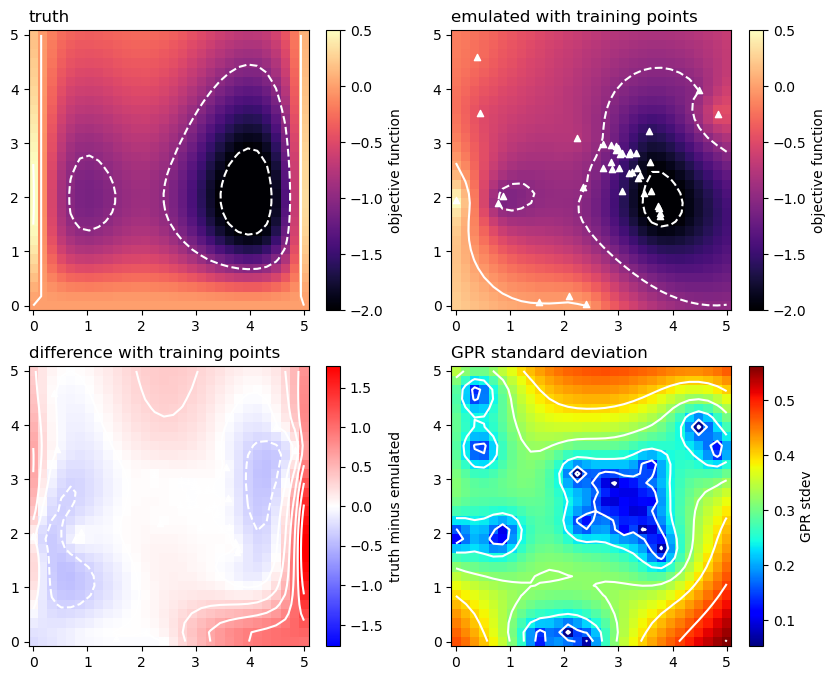

In [36]:
i = 3
gpr_t_d = t_d + "_gpr{0}".format(i-1)
gpr_m_d = gpr_t_d.replace("template","master")
gpr_dvpops = [os.path.join(gpr_m_d,f) for f in os.listdir(gpr_m_d) if len(f.split('.')) == 4 and f.endswith("dv_pop.csv") and "archive" not in f]
gpr_dvpops_itr = [int(f.split(".")[1]) for f in gpr_dvpops]
gpr_dvpops = {itr:pd.read_csv(f,index_col=0) for itr,f in zip(gpr_dvpops_itr,gpr_dvpops)}
# only use the first 10 members of the emulated population to evaluate in the model to make things more interesting
gpr_dvpops[max(gpr_dvpops_itr)].iloc[:10,:].to_csv(os.path.join(t_d,"retrain_{0}_dvpop.csv".format(i)))
pst.pestpp_options["mou_dv_population_file"] = "retrain_{0}_dvpop.csv".format(i)
pst.control_data.noptmax = -1
pst.write(os.path.join(t_d,"pest.pst"))
m_d = "hosaki_model_{0}".format(i)
num_workers = 1
pyemu.os_utils.start_workers(t_d,"pestpp-mou","pest.pst",
                                 num_workers=num_workers,
                                 master_dir=m_d,worker_root='.',
                                 port=port,ppw_function=ppw_function)

training_dvpop_fnamei = os.path.join(m_d,"pest.0.dv_pop.csv")
training_opop_fnamei = os.path.join(m_d,"pest.0.obs_pop.csv")

training_dvpopi = pd.read_csv(training_dvpop_fnamei,index_col=0)
training_opopi = pd.read_csv(training_opop_fnamei,index_col=0)
training_dvpop = pd.concat([training_dvpop,training_dvpopi])
training_opop = pd.concat([training_opop,training_opopi])

fig,ax = plt.subplots(1,1,figsize=(6,5))
get_obj_map(ax,sweep_x,sweep_y,sweep_z)
ax.scatter(training_dvpop.loc[:,pst.par_names[0]],training_dvpop.loc[:,pst.par_names[1]],marker='^',c='w',s=20)
plt.show()
plt.close(fig)

training_dvpop_fnames.append(training_dvpop_fnamei)
training_opop_fnames.append(training_opop_fnamei)
gpr_t_d = t_d + "_gpr{0}".format(i)
gpr_m_d = gpr_t_d.replace("template","master")

gpst = prep_for_gpr(t_d,training_dvpop_fnames,training_opop_fnames,gpr_t_d)
# we only need these files in memory so we can use the speed of PyPestWorker later....
input_df = pd.read_csv(os.path.join(gpr_t_d,"gpr_input.csv"),index_col=0)
mdf = pd.read_csv(os.path.join(gpr_t_d,"gprmodel_info.csv"),index_col=0)
mdf["model_fname"] = mdf.model_fname.apply(lambda x: os.path.join(gpr_t_d,x))
gpr_sweep_d = sweep_d+"_gpr{0}".format(i)
num_workers = 10
pyemu.os_utils.start_workers(gpr_t_d,"pestpp-ies","pest.pst",
                             num_workers=num_workers,
                             master_dir=gpr_sweep_d,worker_root='.',
                             port=port,ppw_function=pyemu.helpers.gpr_pyworker,
                                 ppw_kwargs={"input_df":input_df,
                                            "mdf":mdf})

plot_gpr_sweep_results(gpr_sweep_d,training_dvpop)



noptmax:8, npar_adj:2, nnz_obs:1


             pestpp-mou: multi-objective optimization under uncertainty

                   by the PEST++ development team


version: 5.2.19
binary compiled on Apr 28 2025 at 09:25:40

started at 08/28/25 09:41:29
...processing command line: ' pestpp-mou pest.pst /h :5544'
...using panther run manager in master mode using port 5544

using control file: "pest.pst"
in directory: "/Users/jwhite/Dev/pyemu/examples/hosaki_master_gpr3"
processing control file pest.pst
Note: 3 unused lines in pest control file, see rec file...


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... ..  .:::::.     . ..:::::::....:::.  `: .'
    :..    ____:::::::::.  

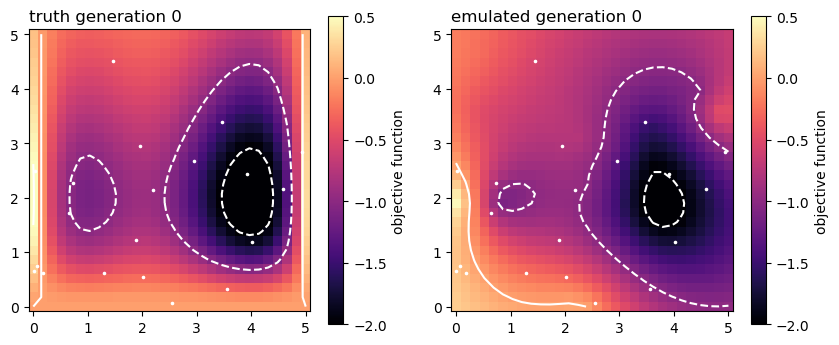

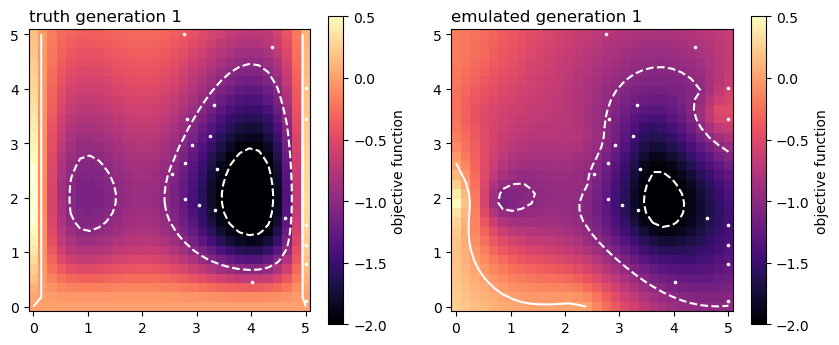

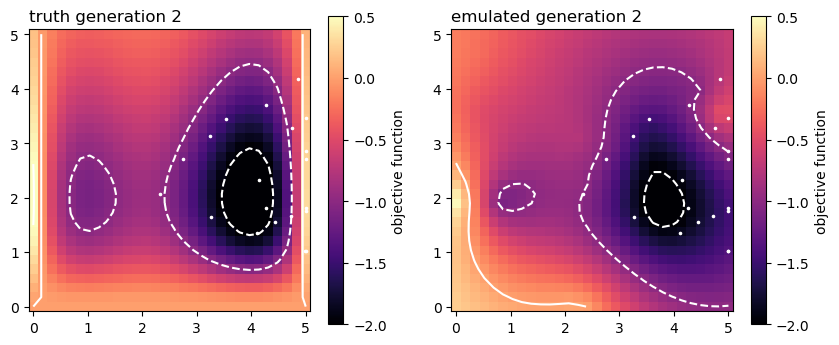

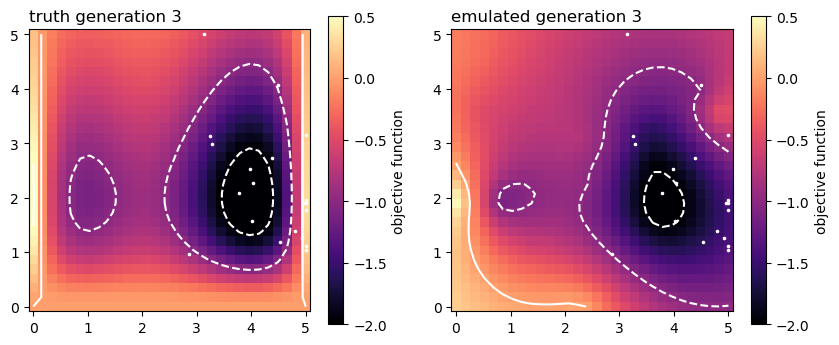

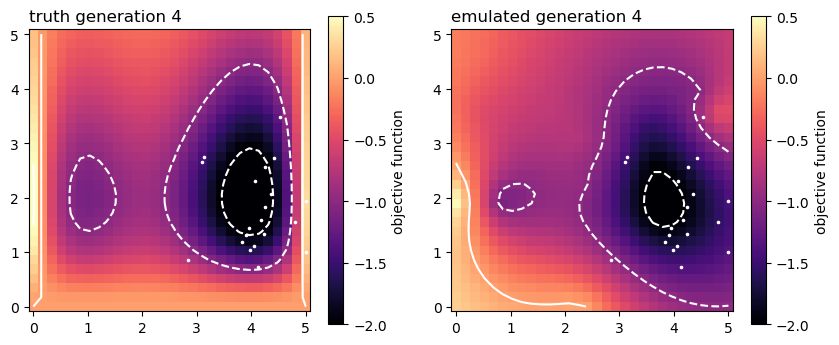

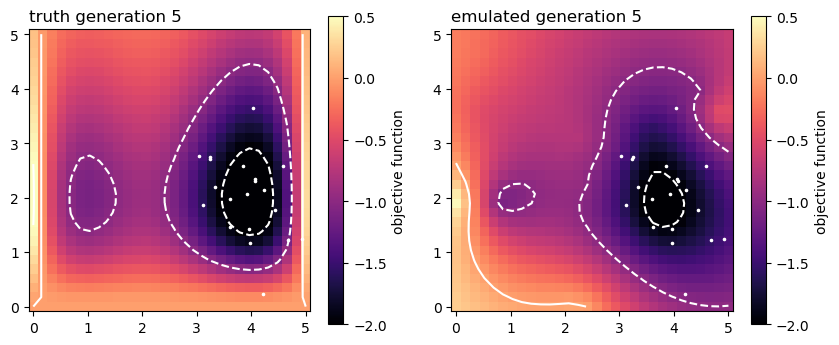

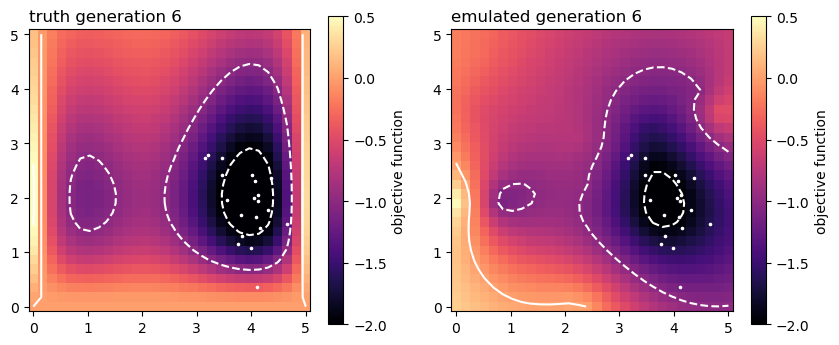

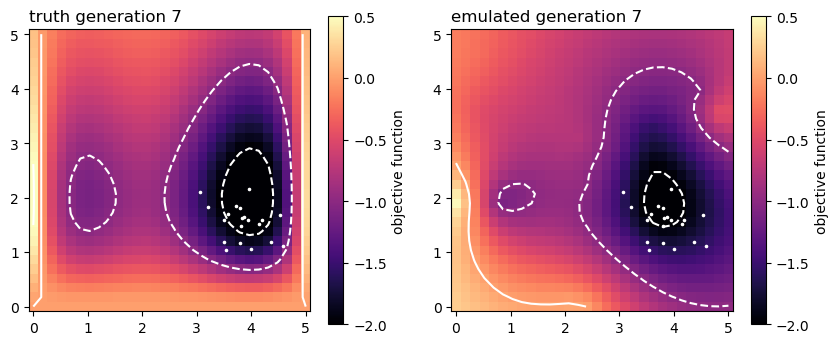

In [37]:
gpst.control_data.noptmax = 8
gpst.pestpp_options["mou_population_size"] = 20
gpst.write(os.path.join(gpr_t_d,"pest.pst"))

num_workers = 3
pyemu.os_utils.start_workers(gpr_t_d,"pestpp-mou","pest.pst",
                             num_workers=num_workers,
                             master_dir=gpr_m_d,worker_root='.',
                             port=port,ppw_function=pyemu.helpers.gpr_pyworker,
                                 ppw_kwargs={"input_df":input_df,
                                            "mdf":mdf})



plot_gpr_mou_results(gpr_m_d,gpr_sweep_d)

And one last time...and this time with more emulator-based pestpp-mou generations to polish things off since we no longer want to keep a dispersed population (since we aren't doing any more in-filling and retraining)

noptmax:-1, npar_adj:2, nnz_obs:1


             pestpp-mou: multi-objective optimization under uncertainty

                   by the PEST++ development team


version: 5.2.19
binary compiled on Apr 28 2025 at 09:25:40

started at 08/28/25 09:41:50
...processing command line: ' pestpp-mou pest.pst /h :5544'
...using panther run manager in master mode using port 5544

using control file: "pest.pst"
in directory: "/Users/jwhite/Dev/pyemu/examples/hosaki_model_4"
processing control file pest.pst
Note: 3 unused lines in pest control file, see rec file...


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... ..  .:::::.     . ..:::::::....:::.  `: .'
    :..    ____:::::::::.  . .

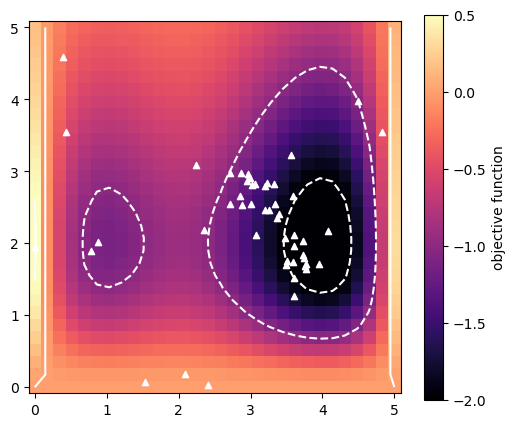

using all adjustable parameters as inputs
input names: ['par1', 'par2']
'mou_objectives' not found in ++ options, using all ineq tagged non-zero weighted obs as objectives
objectives: ['sim']
constraints: []
loading input and output files
...loaded hosaki_model_master/pest.0.dv_pop.csv hosaki_model_master/pest.0.obs_pop.csv
...loaded hosaki_model_master_1/pest.0.dv_pop.csv hosaki_model_master_1/pest.0.obs_pop.csv
...loaded hosaki_model_2/pest.0.dv_pop.csv hosaki_model_2/pest.0.obs_pop.csv
...loaded hosaki_model_3/pest.0.dv_pop.csv hosaki_model_3/pest.0.obs_pop.csv
...loaded hosaki_model_4/pest.0.dv_pop.csv hosaki_model_4/pest.0.obs_pop.csv
aggregated training dataset shape (50, 3) saved to hosaki_template/pest.pst.aggresults.csv
Hyperparameter(name='length_scale', value_type='numeric', bounds=array([[1.e-04, 1.e+04]]), n_elements=1, fixed=False)
training GPR for sim with 50 data points
sim optimized kernel: Matern(length_scale=10.8, nu=0.5)
...plotting fits for sim
GPR model info saved

/Users/jwhite/Dev/pyemu/pyemu/pst/pst_utils.py:922: UserWarning: error processing instruction file hosaki_template_gpr4/gpr_output.csv.ins, trying inschek: output file 'hosaki_template_gpr4/gpr_output.csv' not found


...exit_code: 93382
...status: 0
08/28/25 09:41:57 forward run command(s) finished, took 0.507 seconds
08/28/25 09:41:57 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
08/28/25 09:41:57 done, took 0 seconds


-->08/28/25 09:41:57 run complete, took: 0.507 seconds
-->1 of 1 complete, 0 failed





    ---  serial run manager runs summary:  ---    
    1 of 1 complete, 0 failed
    process took : 0.507 seconds




...saving results from control file parameter value run to  pest.obs.csv

  ---  control file parameter phi report:  ---  
       phi type           mean            std            min            max
       measured        20631.5              0        20631.5        20631.5
         actual        20631.5              0        20631.5        20631.5
     note: 'measured' phi reported above includes 
           realizations of measurement noise, 
           'actual' phi does not.
  ---  observation group phi summary ---  
       (computed us

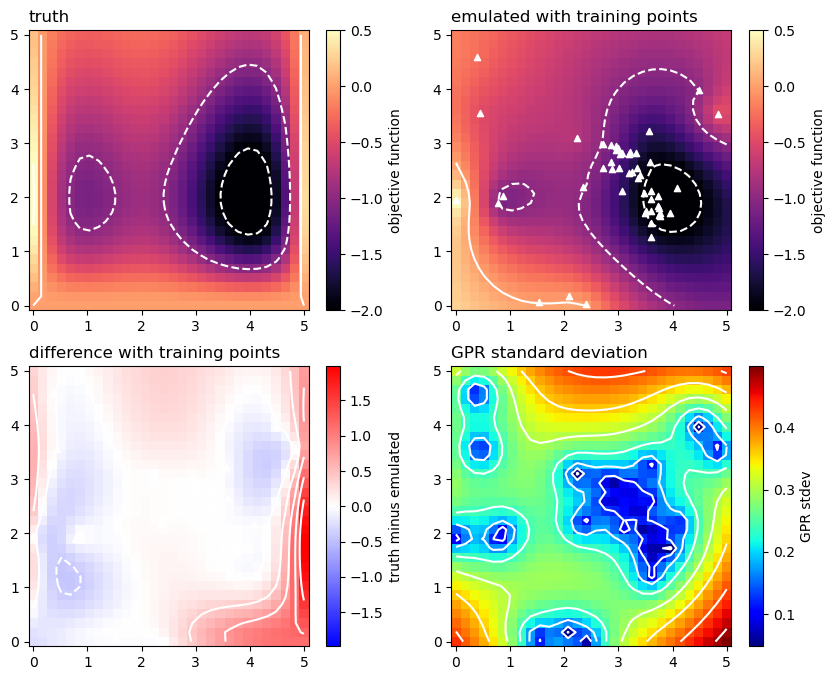

In [38]:
i = 4
gpr_t_d = t_d + "_gpr{0}".format(i-1)
gpr_m_d = gpr_t_d.replace("template","master")
gpr_dvpops = [os.path.join(gpr_m_d,f) for f in os.listdir(gpr_m_d) if len(f.split('.')) == 4 and f.endswith("dv_pop.csv") and "archive" not in f]
gpr_dvpops_itr = [int(f.split(".")[1]) for f in gpr_dvpops]
gpr_dvpops = {itr:pd.read_csv(f,index_col=0) for itr,f in zip(gpr_dvpops_itr,gpr_dvpops)}
# only use the first 10 members of the emulated population to evaluate in the model to make things more interesting
gpr_dvpops[max(gpr_dvpops_itr)].iloc[:10,:].to_csv(os.path.join(t_d,"retrain_{0}_dvpop.csv".format(i)))
pst.pestpp_options["mou_dv_population_file"] = "retrain_{0}_dvpop.csv".format(i)
pst.control_data.noptmax = -1
pst.write(os.path.join(t_d,"pest.pst"))
m_d = "hosaki_model_{0}".format(i)
num_workers = 1
pyemu.os_utils.start_workers(t_d,"pestpp-mou","pest.pst",
                                 num_workers=num_workers,
                                 master_dir=m_d,worker_root='.',
                                 port=port,ppw_function=ppw_function)

training_dvpop_fnamei = os.path.join(m_d,"pest.0.dv_pop.csv")
training_opop_fnamei = os.path.join(m_d,"pest.0.obs_pop.csv")

training_dvpopi = pd.read_csv(training_dvpop_fnamei,index_col=0)
training_opopi = pd.read_csv(training_opop_fnamei,index_col=0)
training_dvpop = pd.concat([training_dvpop,training_dvpopi])
training_opop = pd.concat([training_opop,training_opopi])

fig,ax = plt.subplots(1,1,figsize=(6,5))
get_obj_map(ax,sweep_x,sweep_y,sweep_z)
ax.scatter(training_dvpop.loc[:,pst.par_names[0]],training_dvpop.loc[:,pst.par_names[1]],marker='^',c='w',s=20)
plt.show()
plt.close(fig)

training_dvpop_fnames.append(training_dvpop_fnamei)
training_opop_fnames.append(training_opop_fnamei)
gpr_t_d = t_d + "_gpr{0}".format(i)
gpr_m_d = gpr_t_d.replace("template","master")
gpst = prep_for_gpr(t_d,training_dvpop_fnames,training_opop_fnames,gpr_t_d)
# we only need these files in memory so we can use the speed of PyPestWorker later....
input_df = pd.read_csv(os.path.join(gpr_t_d,"gpr_input.csv"),index_col=0)
mdf = pd.read_csv(os.path.join(gpr_t_d,"gprmodel_info.csv"),index_col=0)
mdf["model_fname"] = mdf.model_fname.apply(lambda x: os.path.join(gpr_t_d,x))
gpr_sweep_d = sweep_d+"_gpr{0}".format(i)
num_workers = 10
pyemu.os_utils.start_workers(gpr_t_d,"pestpp-ies","pest.pst",
                             num_workers=num_workers,
                             master_dir=gpr_sweep_d,worker_root='.',
                             port=port,ppw_function=pyemu.helpers.gpr_pyworker,
                                 ppw_kwargs={"input_df":input_df,
                                            "mdf":mdf})

plot_gpr_sweep_results(gpr_sweep_d,training_dvpop)



noptmax:20, npar_adj:2, nnz_obs:1


             pestpp-mou: multi-objective optimization under uncertainty

                   by the PEST++ development team


version: 5.2.19
binary compiled on Apr 28 2025 at 09:25:40

started at 08/28/25 09:42:24
...processing command line: ' pestpp-mou pest.pst /h :5544'
...using panther run manager in master mode using port 5544

using control file: "pest.pst"
in directory: "/Users/jwhite/Dev/pyemu/examples/hosaki_master_gpr4"
processing control file pest.pst
Note: 3 unused lines in pest control file, see rec file...


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... ..  .:::::.     . ..:::::::....:::.  `: .'
    :..    ____:::::::::. 

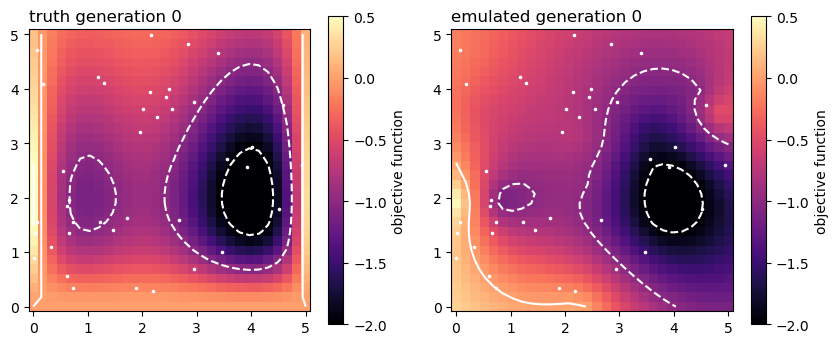

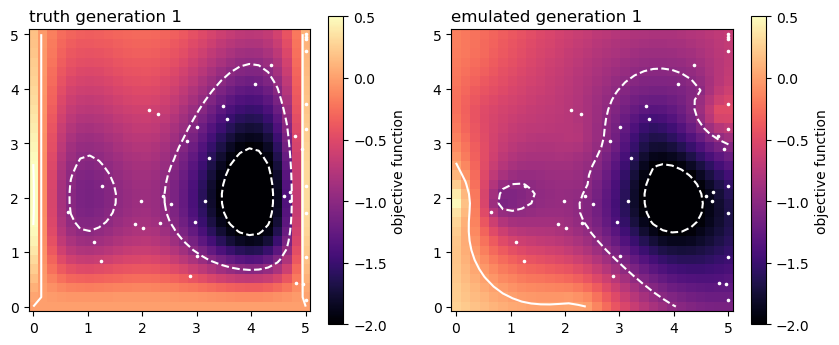

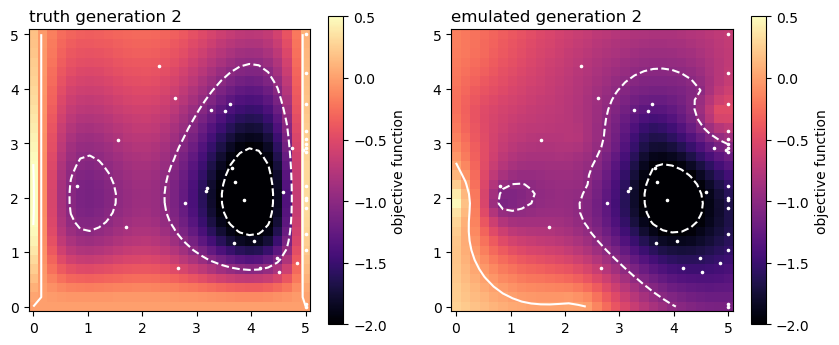

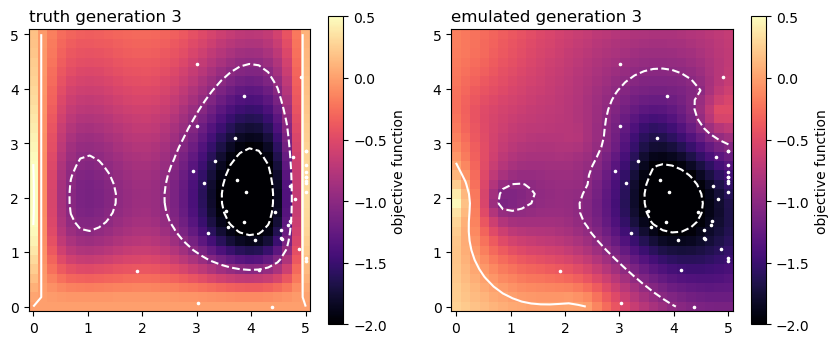

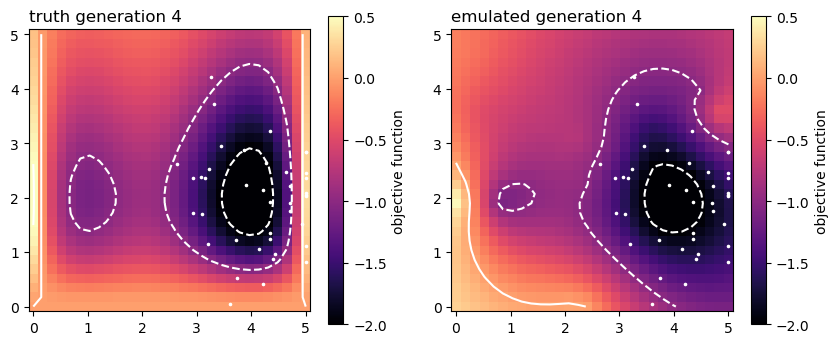

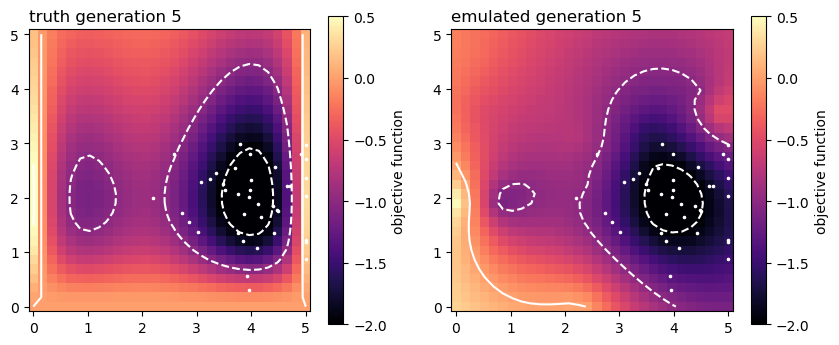

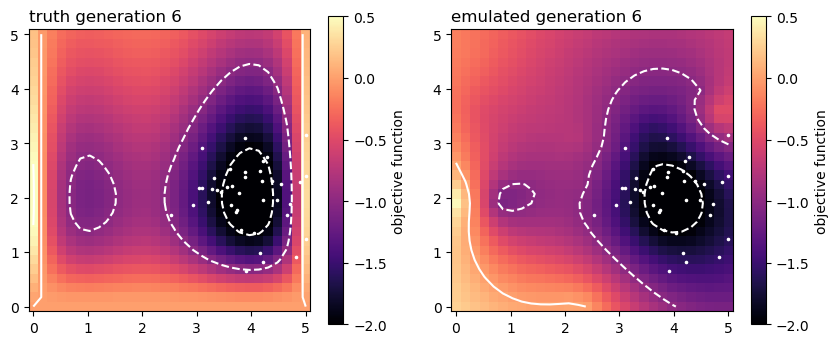

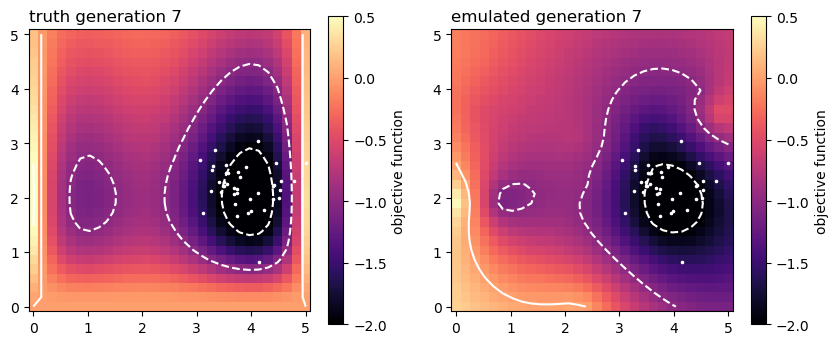

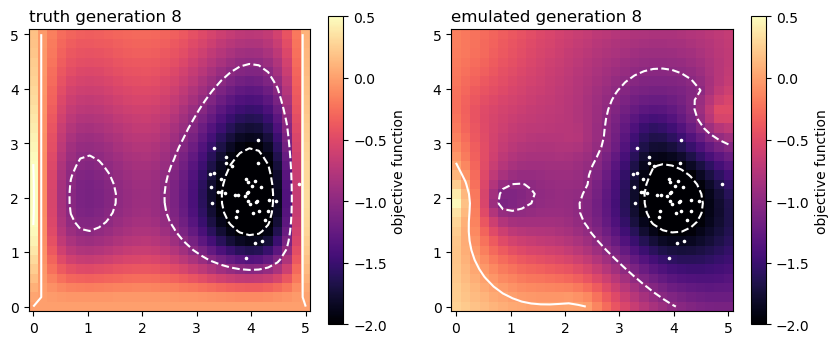

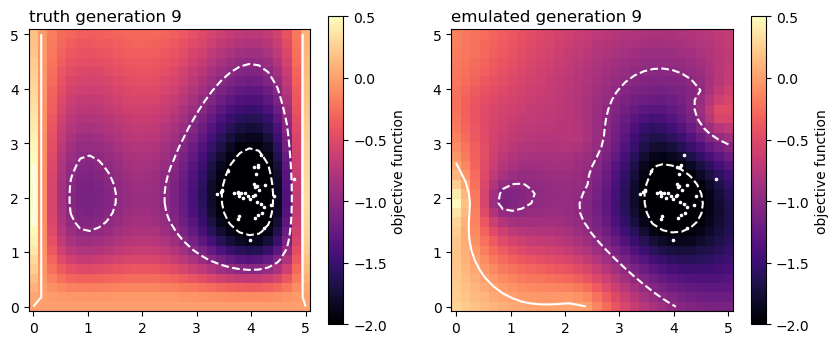

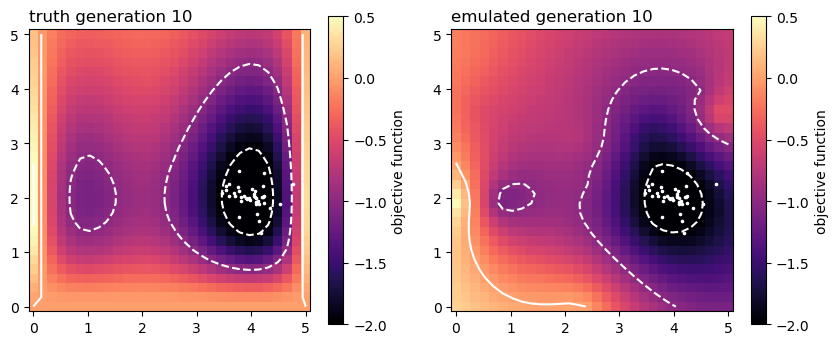

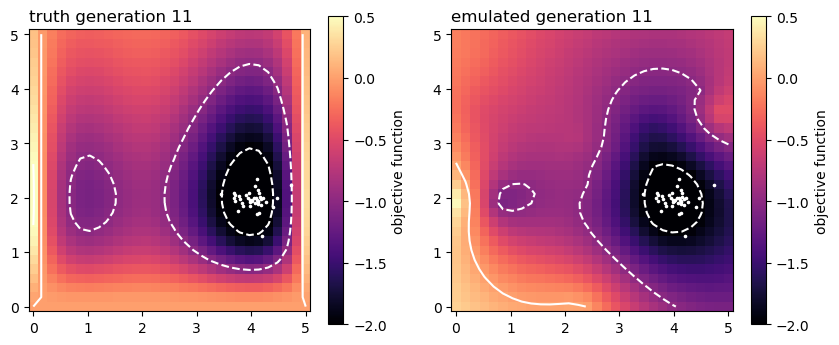

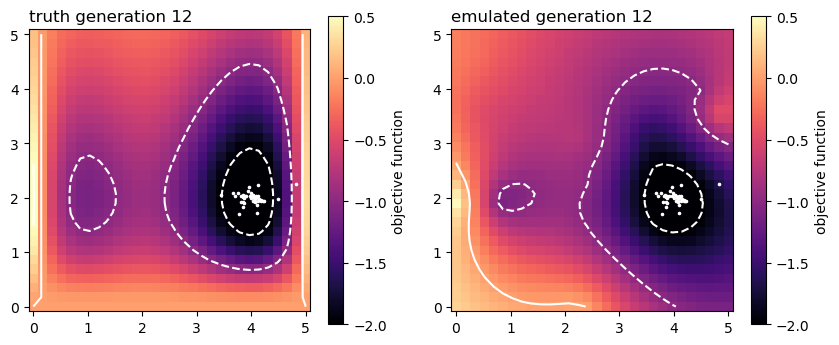

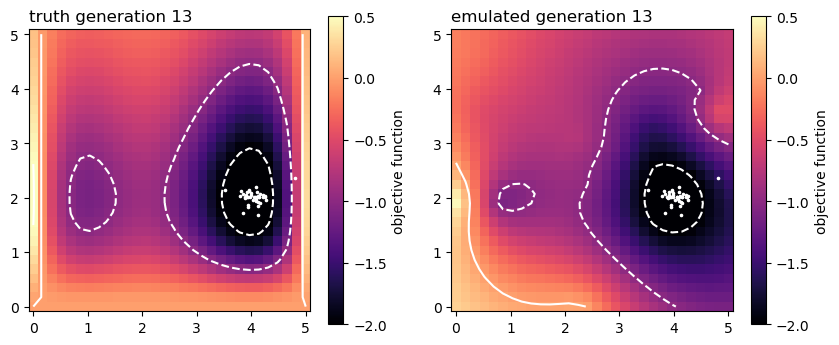

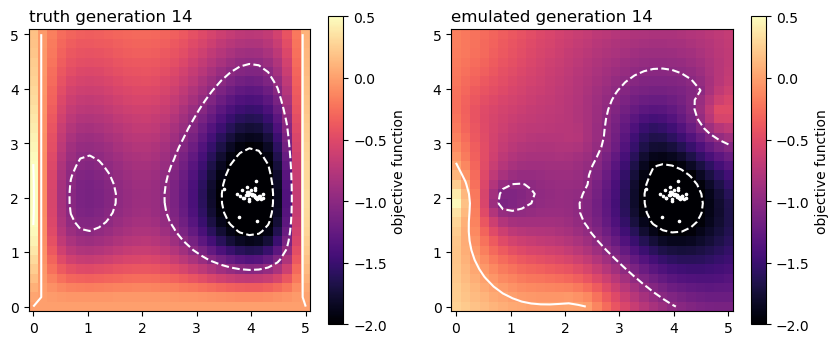

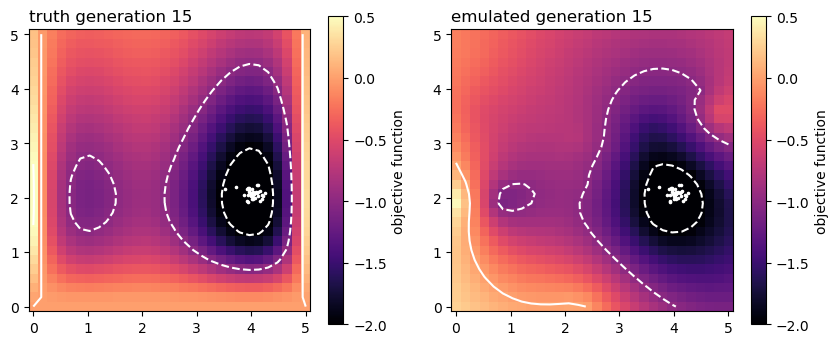

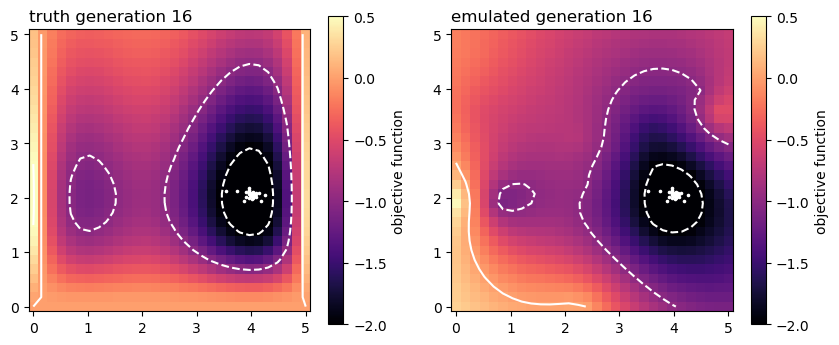

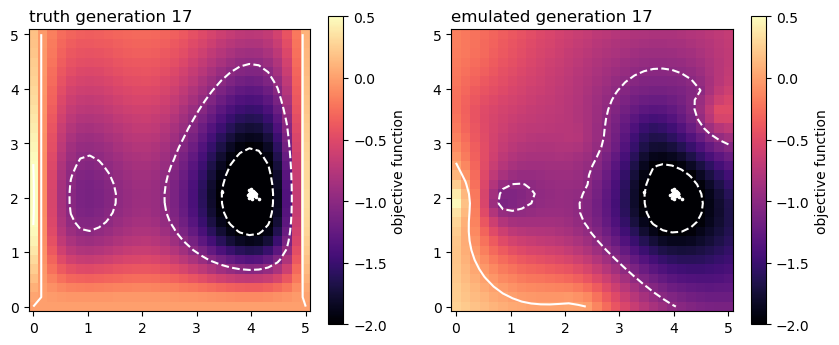

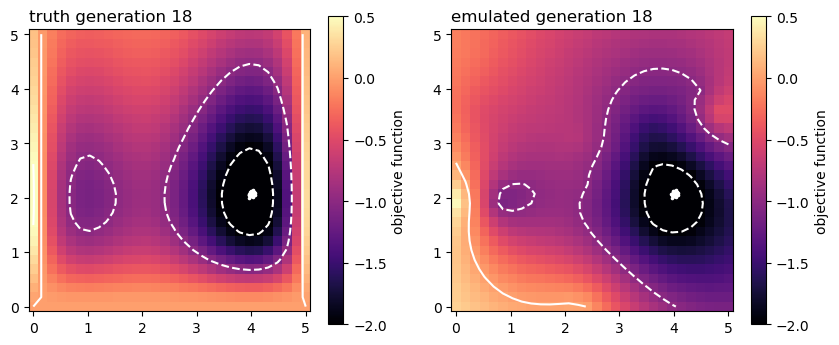

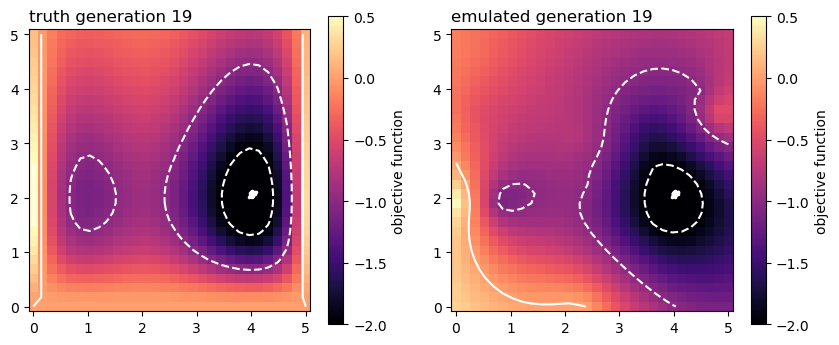

In [39]:
gpst.control_data.noptmax = 20
gpst.pestpp_options["mou_population_size"] = 40
gpst.write(os.path.join(gpr_t_d,"pest.pst"))

num_workers = 5
pyemu.os_utils.start_workers(gpr_t_d,"pestpp-mou","pest.pst",
                             num_workers=num_workers,
                             master_dir=gpr_m_d,worker_root='.',
                             port=port,ppw_function=pyemu.helpers.gpr_pyworker,
                                 ppw_kwargs={"input_df":input_df,
                                            "mdf":mdf})

plot_gpr_mou_results(gpr_m_d,gpr_sweep_d)

There you have it - after evaluating only a few populations with the complex process-based model (here that was only the hosaki function), we can effectively optimize a function with the otherwise every expensive global solvers in pestpp-mou.  In general, this approach can reduce the computational demand of mou by 10X to 100X, which is pretty amazing. In this simple and naive demo, we've only run the true "complex" model at the points listed here:

In [40]:
training_dvpop

par1      par2
real_name                               
gen=0_member=0        0.438363  3.552073
gen=0_member=1        0.004214  1.950713
gen=0_member=2        0.775812  1.888000
gen=0_member=3        1.526807  0.074558
gen=0_member=4        0.390467  4.585152
gen=0_member=5        2.349584  2.188475
gen=0_member=6        2.408875  0.022861
gen=0_member=7        2.081523  0.184029
gen=0_member=8        0.873526  2.021348
gen=0_member=9        2.962505  2.956024
gen=8_member=601_pso  2.864985  2.974944
gen=8_member=603_pso  3.335076  2.545988
gen=8_member=605_pso  3.327992  2.819719
gen=8_member=607_pso  4.492209  3.978877
gen=8_member=609_pso  3.023478  2.809313
gen=8_member=611_pso  3.059075  2.817852
gen=8_member=613_pso  3.198714  2.795534
gen=8_member=615_pso  2.949061  2.868802
gen=8_member=617_pso  2.721115  2.981098
gen=8_member=619_pso  2.235942  3.092054
gen=8_member=601_pso  2.712920  2.541080
gen=8_member=603_pso  2.859277  2.662069
gen=8_member=605_pso  2.997683  2.904778
gen=8_member=607_pso  3.472390  2.075998
gen=8_member=609_pso  3.003319  2.542013
gen=8_member=611_pso  4.832405  3.543590
gen=8_member=613_pso  3.370240  2.357476
gen=8_member=615_pso  3.564098  3.224815
gen=8_member=617_pso  3.071015  2.119999
gen=8_member=619_pso  3.588149  2.650685
gen=8_member=301_pso  3.222767  2.836802
gen=8_member=303_pso  3.766701  1.646752
gen=8_member=305_pso  3.734532  1.842923
gen=8_member=307_pso  3.197880  2.455361
gen=8_member=309_pso  3.775591  1.704509
gen=8_member=311_pso  3.610508  2.118310
gen=8_member=313_pso  3.253277  2.468098
gen=8_member=315_pso  3.744820  1.798785
gen=8_member=317_pso  3.399876  2.408492
gen=8_member=319_pso  2.884910  2.526304
gen=8_member=301_pso  3.958313  1.712891
gen=8_member=303_pso  3.597151  1.961165
gen=8_member=305_pso  3.495247  1.702629
gen=8_member=307_pso  4.081232  2.167714
gen=8_member=309_pso  3.599650  1.259749
gen=8_member=311_pso  3.511558  1.749567
gen=8_member=313_pso  3.598446  1.518651
gen=8_member=315_pso  3.734549  2.024863
gen=8_member=317_pso  3.755276  1.681237
gen=8_member=319_pso  3.595699  1.739098

In [41]:
print("The complex model has only been run {0} times!!!".format(training_dvpop.shape[0]))

The complex model has only been run 50 times!!!
